In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('default')
import yfinance as yf
from datetime import datetime

In [2]:
# Define the ticker symbol
ticker_symbol = 'BRIS.JK'

# Fetch the data
bris_data = yf.download(ticker_symbol, start='2019-03-11', end='2024-03-11')
bris_data

[*********************100%%**********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-03-11   526.666748   526.666748   521.790222   521.790222   511.426331   
2019-03-12   521.790222   526.666748   521.790222   526.666748   516.205933   
2019-03-13   521.790222   526.666748   516.913696   521.790222   511.426331   
2019-03-14   521.790222   526.666748   516.913696   521.790222   511.426331   
2019-03-15   526.666748   531.543335   521.790222   526.666748   516.205933   
...                 ...          ...          ...          ...          ...   
2024-03-04  2420.000000  2450.000000  2380.000000  2410.000000  2410.000000   
2024-03-05  2410.000000  2450.000000  2410.000000  2430.000000  2430.000000   
2024-03-06  2430.000000  2480.000000  2400.000000  2470.000000  2470.000000   
2024-03-07  2500.000000  2520.000000  2470.000000  2480.000000  2480.000000   
2024-03-08  2500.000000  2620.000000  2470.000000  2600.000000  2600.000000   

              Volume  
Date                  
2019-03-11   1197364  
2019-03-12   3319974  
2019-03-13   2884419  
2019-03-14   1535616  
2019-03-15   4844824  
...              ...  
2024-03-04  22411600  
2024-03-05  18420700  
2024-03-06  25245100  
2024-03-07  31395800  
2024-03-08  74013000  

[1229 rows x 6 columns]

In [3]:
# drop 0 value in Volume
bris_data = bris_data[bris_data.Volume != 0]

#Data telah bersih
a = bris_data[bris_data.Volume == 0]
len(a)

bris_data

Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-03-11   526.666748   526.666748   521.790222   521.790222   511.426331   
2019-03-12   521.790222   526.666748   521.790222   526.666748   516.205933   
2019-03-13   521.790222   526.666748   516.913696   521.790222   511.426331   
2019-03-14   521.790222   526.666748   516.913696   521.790222   511.426331   
2019-03-15   526.666748   531.543335   521.790222   526.666748   516.205933   
...                 ...          ...          ...          ...          ...   
2024-03-04  2420.000000  2450.000000  2380.000000  2410.000000  2410.000000   
2024-03-05  2410.000000  2450.000000  2410.000000  2430.000000  2430.000000   
2024-03-06  2430.000000  2480.000000  2400.000000  2470.000000  2470.000000   
2024-03-07  2500.000000  2520.000000  2470.000000  2480.000000  2480.000000   
2024-03-08  2500.000000  2620.000000  2470.000000  2600.000000  2600.000000   

              Volume  
Date                  
2019-03-11   1197364  
2019-03-12   3319974  
2019-03-13   2884419  
2019-03-14   1535616  
2019-03-15   4844824  
...              ...  
2024-03-04  22411600  
2024-03-05  18420700  
2024-03-06  25245100  
2024-03-07  31395800  
2024-03-08  74013000  

[1219 rows x 6 columns]

In [4]:
# Create a new dataframe with only the Close column 
data = bris_data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.90) # 90% 10%

# Split dataset into training and testing sets
train_data = dataset[:training_data_len]
test_data = dataset[training_data_len:]

# Normalize data
# Scale the data 
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_train_data

array([[0.11004127],
       [0.11141678],
       [0.11004127],
       ...,
       [0.42545218],
       [0.42968319],
       [0.42545218]])

In [5]:
print(scaled_train_data.shape)
print(len(scaled_train_data))

(1098, 1)
1098


In [6]:
from keras.layers import Activation
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
# Function to train LSTM model and return predictions and RMSE
def train_lstm_model(x_train, y_train, x_test, actual):
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1), activation='tanh'))
    model.add(Dropout(0.2))  # Adding dropout with a rate of 0.2
    model.add(LSTM(50, return_sequences=False, activation='tanh'))
    model.add(Dropout(0.2))  # Adding dropout with a rate of 0.2
    model.add(Dense(25, activation='linear'))  # Adding a linear activation function
    model.add(Dense(1))

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, actual),
              callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, verbose=1, mode='min')], verbose= 1, shuffle=False)

    # Get the models predicted price values from train
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions) # unscaling the values

    # Get the root mean squared error (RMSE)
    rmse= np.sqrt(np.mean(((predictions - actual)**2)))
    mape= np.mean(np.abs((actual - predictions) / actual)) * 100
    
    return predictions, rmse, mape

In [7]:
# Create empty lists to store results
all_predictions = []
all_rmse = []
all_mape = []

# Perform 50 runs of LSTM
for i in range(50):
    print(f"Run: {i+1}")
    # Create the scaled training data set with window size = 100
    train_data = scaled_train_data
    #split the data into x_train and y_train dataset
    x_train = []
    y_train = []
    for i in range(100, len(train_data)):
        x_train.append(train_data[i-100:i])
        y_train.append(train_data[i])
    # Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    print(len(x_train))
    print(len(y_train))
    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Create the scaled testing data set
    testing_data = dataset[training_data_len-100:]
    test_data = scaler.transform(testing_data.reshape(-1,1))
    # Create the dataset x_test and y_test
    x_test = []
    for i in range(100, len(test_data)):
        x_test.append(test_data[i-100:i])
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    actual = dataset[training_data_len:]
    # Train LSTM model and return predictions, RMSE, and MAPE
    predictions, rmse, mape = train_lstm_model(x_train, y_train, x_test, actual)
    
    # Append predictions and RMSE to lists
    all_predictions.append(predictions)
    all_rmse.append(rmse)
    all_mape.append(mape)

Run: 1
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0140 - val_loss: 3605152.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0119 - val_loss: 3605091.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0048 - val_loss: 3604931.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0033 - val_loss: 3604796.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604783.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0031 - val_loss: 3604793.7500
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0032 - val_loss: 3604801.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 3604796.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - val_loss: 3604771.7500
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0022 - val_loss: 3604850.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0037 - val_loss: 3604704.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0130 - val_loss: 3604995.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0122 - val_loss: 3604894.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0034 - val_loss: 3604781.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0034 - val_loss: 3604804.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0032 - val_loss: 3604787.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 3604796.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0034 - val_loss: 3604744.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0021 - val_loss: 3604807.2500
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0037 - val_loss: 3604727.2500
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604755.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0021 - val_loss: 3604818.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0153 - val_loss: 3605179.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0129 - val_loss: 3605085.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0054 - val_loss: 3604937.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0031 - val_loss: 3604830.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0027 - val_loss: 3604781.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0031 - val_loss: 3604819.2500
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0031 - val_loss: 3604775.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0021 - val_loss: 3604768.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0028 - val_loss: 3604757.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0021 - val_loss: 3604775.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604781.0000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0134 - val_loss: 3605080.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0129 - val_loss: 3604973.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0043 - val_loss: 3604818.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0035 - val_loss: 3604786.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0032 - val_loss: 3604780.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0030 - val_loss: 3604812.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0040 - val_loss: 3604765.7500
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0019 - val_loss: 3604776.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0031 - val_loss: 3604749.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0023 - val_loss: 3604802.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 3604776.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0123 - val_loss: 3605006.7500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0121 - val_loss: 3604910.2500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0034 - val_loss: 3604778.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0030 - val_loss: 3604793.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0034 - val_loss: 3604767.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0034 - val_loss: 3604689.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0023 - val_loss: 3604798.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0028 - val_loss: 3604760.2500
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0032 - val_loss: 3604751.2500
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0022 - val_loss: 3604781.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604733.7500
Epoch 11

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0114 - val_loss: 3604912.7500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0123 - val_loss: 3604888.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0034 - val_loss: 3604775.2500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 3604779.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - val_loss: 3604738.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 3604766.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 3604746.7500
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0042 - val_loss: 3604738.2500
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0020 - val_loss: 3604832.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604746.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 7
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0131 - val_loss: 3605027.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0125 - val_loss: 3604941.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0037 - val_loss: 3604772.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0029 - val_loss: 3604783.7500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604795.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0032 - val_loss: 3604708.7500
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 3604746.2500
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 3604829.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0036 - val_loss: 3604743.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 3604750.2500
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0020 - val_loss: 3604806.5000
Epoch 11

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0120 - val_loss: 3605006.7500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0104 - val_loss: 3604922.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0031 - val_loss: 3604770.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 3604787.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604754.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0027 - val_loss: 3604754.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 3604762.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 3604759.7500
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0049 - val_loss: 3604716.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0019 - val_loss: 3604810.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0021 - val_loss: 3604786.0000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0160 - val_loss: 3605196.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0112 - val_loss: 3605062.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0048 - val_loss: 3604878.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0033 - val_loss: 3604785.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0030 - val_loss: 3604782.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 3604754.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - val_loss: 3604788.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 3604826.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0034 - val_loss: 3604727.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0024 - val_loss: 3604796.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 3604804.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0211 - val_loss: 3605284.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0157 - val_loss: 3605121.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0088 - val_loss: 3605031.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0037 - val_loss: 3604913.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0032 - val_loss: 3604818.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0028 - val_loss: 3604767.7500
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0030 - val_loss: 3604795.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0025 - val_loss: 3604829.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0026 - val_loss: 3604774.2500
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0024 - val_loss: 3604773.5000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0023 - val_loss: 3604766.0000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0121 - val_loss: 3605003.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0133 - val_loss: 3604924.7500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0041 - val_loss: 3604785.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - val_loss: 3604799.7500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0039 - val_loss: 3604760.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 3604784.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604784.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0035 - val_loss: 3604739.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 3604782.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604836.7500
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0047 - val_loss: 3604727.0000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0174 - val_loss: 3605192.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0117 - val_loss: 3605082.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0052 - val_loss: 3604937.7500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0031 - val_loss: 3604816.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 3604811.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0032 - val_loss: 3604830.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604807.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 3604813.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0028 - val_loss: 3604750.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604783.7500
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 3604810.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0177 - val_loss: 3605268.7500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0152 - val_loss: 3605147.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0079 - val_loss: 3605054.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0039 - val_loss: 3604896.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 3604799.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604778.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604793.7500
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604814.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604797.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 3604791.2500
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 3604821.0000
Epoch 11

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0160 - val_loss: 3605191.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0102 - val_loss: 3605047.2500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0048 - val_loss: 3604914.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604793.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0028 - val_loss: 3604801.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0024 - val_loss: 3604762.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604774.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0023 - val_loss: 3604770.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 3604764.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0022 - val_loss: 3604780.5000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 3604770.5000
Epoch 11

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0158 - val_loss: 3605206.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0129 - val_loss: 3605094.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0054 - val_loss: 3604911.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0038 - val_loss: 3604768.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0031 - val_loss: 3604776.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 3604778.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 3604751.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604817.7500
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 3604768.7500
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0034 - val_loss: 3604747.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0017 - val_loss: 3604811.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0162 - val_loss: 3605214.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0111 - val_loss: 3605090.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0050 - val_loss: 3604928.2500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0030 - val_loss: 3604833.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 3604770.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 3604723.7500
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604820.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 3604778.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604812.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0019 - val_loss: 3604789.2500
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0041 - val_loss: 3604750.0000
Epoch 11

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0142 - val_loss: 3605132.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0113 - val_loss: 3605024.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0042 - val_loss: 3604822.7500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0036 - val_loss: 3604771.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604816.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0035 - val_loss: 3604778.7500
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604829.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0044 - val_loss: 3604730.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 3604816.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - val_loss: 3604768.7500
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022 - val_loss: 3604804.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0148 - val_loss: 3605229.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0124 - val_loss: 3605078.7500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0057 - val_loss: 3604940.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 3604806.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0031 - val_loss: 3604782.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604772.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0032 - val_loss: 3604786.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0027 - val_loss: 3604764.2500
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0023 - val_loss: 3604782.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604754.5000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0024 - val_loss: 3604788.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0181 - val_loss: 3605266.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0130 - val_loss: 3605164.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0071 - val_loss: 3605048.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0043 - val_loss: 3604940.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0030 - val_loss: 3604838.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0029 - val_loss: 3604785.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0026 - val_loss: 3604776.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0026 - val_loss: 3604813.7500
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0024 - val_loss: 3604790.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0029 - val_loss: 3604785.5000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 3604783.7500
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0143 - val_loss: 3605094.7500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0098 - val_loss: 3604931.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0037 - val_loss: 3604779.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0027 - val_loss: 3604773.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0030 - val_loss: 3604796.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0032 - val_loss: 3604748.7500
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 3604747.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0020 - val_loss: 3604796.7500
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0023 - val_loss: 3604757.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0019 - val_loss: 3604793.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0027 - val_loss: 3604731.7500
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0166 - val_loss: 3605209.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0135 - val_loss: 3605109.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0048 - val_loss: 3604940.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604805.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0027 - val_loss: 3604789.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0032 - val_loss: 3604755.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0031 - val_loss: 3604724.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0020 - val_loss: 3604798.2500
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604770.2500
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0027 - val_loss: 3604732.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0018 - val_loss: 3604810.0000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0175 - val_loss: 3605228.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0128 - val_loss: 3605075.7500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0060 - val_loss: 3604956.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0029 - val_loss: 3604791.7500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0025 - val_loss: 3604765.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0026 - val_loss: 3604815.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0027 - val_loss: 3604787.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 3604776.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 3604760.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0020 - val_loss: 3604806.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 3604755.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0173 - val_loss: 3605263.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0128 - val_loss: 3605103.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0066 - val_loss: 3604975.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 3604819.7500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - val_loss: 3604800.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022 - val_loss: 3604789.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604766.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604790.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0028 - val_loss: 3604723.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0043 - val_loss: 3604784.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0026 - val_loss: 3604869.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0198 - val_loss: 3605273.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0147 - val_loss: 3605116.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0070 - val_loss: 3604992.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0035 - val_loss: 3604858.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0029 - val_loss: 3604761.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604767.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0028 - val_loss: 3604783.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0028 - val_loss: 3604772.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 3604801.7500
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0030 - val_loss: 3604767.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run: 25
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0116 - val_loss: 3604861.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0113 - val_loss: 3604814.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0030 - val_loss: 3604788.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0033 - val_loss: 3604765.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 3604773.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604753.2500
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0037 - val_loss: 3604734.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604787.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 3604779.2500
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0038 - val_loss: 3604723.2500
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0016 - val_loss: 3604811.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0176 - val_loss: 3605200.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0157 - val_loss: 3605107.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0068 - val_loss: 3604945.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0038 - val_loss: 3604836.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604808.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0032 - val_loss: 3604774.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0032 - val_loss: 3604841.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0030 - val_loss: 3604844.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0056 - val_loss: 3604720.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0021 - val_loss: 3604833.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0041 - val_loss: 3604766.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0131 - val_loss: 3605090.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0120 - val_loss: 3604993.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0041 - val_loss: 3604808.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 3604742.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 3604798.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604772.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 3604750.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604778.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604779.5000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 28
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0160 - val_loss: 3605218.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0133 - val_loss: 3605077.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0062 - val_loss: 3604953.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 3604806.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604793.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 3604791.2500
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 3604767.7500
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 3604775.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0026 - val_loss: 3604740.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0022 - val_loss: 3604793.5000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 3604759.0000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0201 - val_loss: 3605264.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0144 - val_loss: 3605122.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0081 - val_loss: 3605093.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0047 - val_loss: 3604984.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0035 - val_loss: 3604892.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 3604815.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0028 - val_loss: 3604777.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0025 - val_loss: 3604781.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 3604764.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604756.5000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0024 - val_loss: 3604820.0000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0150 - val_loss: 3605166.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0117 - val_loss: 3605064.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0045 - val_loss: 3604875.2500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 3604798.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - val_loss: 3604833.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 3604718.7500
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 3604802.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0028 - val_loss: 3604778.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604747.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0020 - val_loss: 3604804.5000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 3604794.0000
Epoch 11

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0137 - val_loss: 3605142.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0117 - val_loss: 3605034.7500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0045 - val_loss: 3604883.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 3604760.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604802.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0034 - val_loss: 3604799.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0034 - val_loss: 3604733.7500
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 3604830.2500
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0035 - val_loss: 3604779.7500
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604735.5000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0023 - val_loss: 3604797.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0181 - val_loss: 3605235.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0122 - val_loss: 3605094.2500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0062 - val_loss: 3605005.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 3604849.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0027 - val_loss: 3604788.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0026 - val_loss: 3604735.7500
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 3604780.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 3604788.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0030 - val_loss: 3604737.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0020 - val_loss: 3604781.5000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604744.5000
Epoch 11

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0181 - val_loss: 3605232.7500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0122 - val_loss: 3605095.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0057 - val_loss: 3604936.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - val_loss: 3604801.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 3604767.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0031 - val_loss: 3604785.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 3604755.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022 - val_loss: 3604776.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604735.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 3604780.2500
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 3604786.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0118 - val_loss: 3604934.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0111 - val_loss: 3604846.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0041 - val_loss: 3604794.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0034 - val_loss: 3604807.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0035 - val_loss: 3604749.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0025 - val_loss: 3604823.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0037 - val_loss: 3604741.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604787.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0024 - val_loss: 3604791.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0038 - val_loss: 3604740.2500
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0027 - val_loss: 3604773.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0131 - val_loss: 3605159.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0119 - val_loss: 3605028.2500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0046 - val_loss: 3604850.7500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 3604783.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604795.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0030 - val_loss: 3604745.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 3604783.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 3604743.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604755.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022 - val_loss: 3604797.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604749.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0222 - val_loss: 3605299.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0157 - val_loss: 3605145.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0092 - val_loss: 3605008.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0040 - val_loss: 3604905.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604793.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604807.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0026 - val_loss: 3604777.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0025 - val_loss: 3604771.2500
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0024 - val_loss: 3604809.7500
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604796.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 3604784.0000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0181 - val_loss: 3605217.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0119 - val_loss: 3605078.2500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0052 - val_loss: 3604977.2500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0034 - val_loss: 3604835.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - val_loss: 3604789.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604745.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604779.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604771.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022 - val_loss: 3604822.2500
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - val_loss: 3604792.5000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0039 - val_loss: 3604728.0000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0186 - val_loss: 3605231.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0114 - val_loss: 3605080.2500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0052 - val_loss: 3604974.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - val_loss: 3604855.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604803.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 3604812.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604788.2500
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0035 - val_loss: 3604734.2500
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0026 - val_loss: 3604806.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0028 - val_loss: 3604810.5000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 3604759.0000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0176 - val_loss: 3605184.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0133 - val_loss: 3605087.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0050 - val_loss: 3604932.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - val_loss: 3604754.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604721.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604797.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0036 - val_loss: 3604775.7500
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604784.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0022 - val_loss: 3604814.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0036 - val_loss: 3604756.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 40
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0108 - val_loss: 3604893.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0130 - val_loss: 3604872.7500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0029 - val_loss: 3604786.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 3604761.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0036 - val_loss: 3604771.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0025 - val_loss: 3604796.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0029 - val_loss: 3604748.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 3604753.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604792.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604759.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0036 - val_loss: 3604743.0000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0151 - val_loss: 3605227.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0136 - val_loss: 3605112.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0065 - val_loss: 3604991.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0035 - val_loss: 3604838.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 3604756.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604789.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604800.2500
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604782.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0022 - val_loss: 3604786.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0020 - val_loss: 3604802.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 42
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0108 - val_loss: 3604931.7500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0120 - val_loss: 3604893.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0033 - val_loss: 3604741.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604780.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 3604825.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 3604728.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0043 - val_loss: 3604754.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0018 - val_loss: 3604797.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0037 - val_loss: 3604723.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0016 - val_loss: 3604792.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 3604782.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0167 - val_loss: 3605152.7500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0134 - val_loss: 3605066.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0051 - val_loss: 3604942.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0034 - val_loss: 3604774.7500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604763.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 3604764.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604796.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604781.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 3604746.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0018 - val_loss: 3604795.5000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0034 - val_loss: 3604714.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0180 - val_loss: 3605272.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0134 - val_loss: 3605133.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0071 - val_loss: 3605034.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0037 - val_loss: 3604917.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0029 - val_loss: 3604832.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604803.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0027 - val_loss: 3604794.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0025 - val_loss: 3604821.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0026 - val_loss: 3604818.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0028 - val_loss: 3604778.5000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604818.0000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0142 - val_loss: 3605061.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0118 - val_loss: 3604963.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0036 - val_loss: 3604817.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604787.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 3604781.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 3604774.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604791.2500
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0036 - val_loss: 3604753.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0036 - val_loss: 3604718.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 3604803.5000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604767.0000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0117 - val_loss: 3604931.7500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0133 - val_loss: 3604876.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0035 - val_loss: 3604756.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604798.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 3604798.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0036 - val_loss: 3604788.2500
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0037 - val_loss: 3604738.7500
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022 - val_loss: 3604760.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 3604752.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 3604789.2500
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 3604783.5000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0188 - val_loss: 3605286.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0158 - val_loss: 3605161.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0089 - val_loss: 3605087.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0042 - val_loss: 3604996.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - val_loss: 3604895.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0030 - val_loss: 3604840.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0030 - val_loss: 3604798.2500
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 3604802.2500
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 3604818.2500
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 3604778.5000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 3604828.0000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0140 - val_loss: 3605168.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0099 - val_loss: 3605053.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0046 - val_loss: 3604894.2500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0030 - val_loss: 3604756.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0028 - val_loss: 3604783.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0022 - val_loss: 3604818.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0033 - val_loss: 3604753.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0035 - val_loss: 3604732.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 3604815.2500
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0030 - val_loss: 3604725.2500
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0020 - val_loss: 3604776.2500
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0162 - val_loss: 3605207.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0134 - val_loss: 3605093.7500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0067 - val_loss: 3604951.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0036 - val_loss: 3604798.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0035 - val_loss: 3604779.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0034 - val_loss: 3604781.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0027 - val_loss: 3604793.5000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0025 - val_loss: 3604761.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0036 - val_loss: 3604772.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0023 - val_loss: 3604779.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0040 - val_loss: 3604731.0000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0187 - val_loss: 3605250.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0137 - val_loss: 3605096.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0069 - val_loss: 3604988.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 3604856.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0029 - val_loss: 3604778.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 3604812.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0026 - val_loss: 3604805.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0027 - val_loss: 3604793.5000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 3604810.5000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0026 - val_loss: 3604793.5000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [8]:
# Create DataFrame to store results
results_df = pd.DataFrame()

# Add predictions to DataFrame
for i in range(50):
    col_name = f'Prediction_{i+1}'
    predictions_series = pd.Series(all_predictions[i].reshape(-1), name=col_name)
    results_df = pd.concat([results_df, predictions_series], axis=1)

# Add RMSE & MAPE as a row to DataFrame if the lengths match
results_df.loc['RMSE'] = all_rmse
results_df.loc['MAPE'] = all_mape

# Calculate average of predictions from Prediction_1 to Prediction_50
results_df['Average_Prediction'] = results_df.iloc[:, :].mean(axis=1)

# Calculate standard deviation of predictions from Prediction_1 to Prediction_50
results_df['Prediction_Std'] = results_df.iloc[:, :-1].std(axis=1)

# Print results DataFrame
print(results_df)

      Prediction_1  Prediction_2  Prediction_3  Prediction_4  Prediction_5  \
0      1726.910767   1685.769653   1676.205078   1728.127319   1742.441406   
1      1723.768799   1683.557861   1674.182983   1725.252808   1739.878662   
2      1722.202759   1682.626587   1673.921509   1724.193726   1738.789795   
3      1721.293579   1682.210327   1674.213379   1723.876221   1738.240112   
4      1716.847412   1678.929810   1670.137207   1719.593628   1734.160767   
...            ...           ...           ...           ...           ...   
118    2468.639404   2221.117432   2290.256592   2440.887207   2405.534912   
119    2468.211426   2220.150391   2288.988281   2439.281738   2404.913574   
120    2470.126953   2221.235596   2290.924561   2440.725830   2406.687012   
RMSE     74.964555    141.058218    107.809284     78.667134     96.179871   
MAPE      3.647207      5.373835      4.137605      3.884354      4.807157   

      Prediction_6  Prediction_7  Prediction_8  Prediction_9  P

In [9]:
# Save DataFrame to CSV with header
results_df.to_csv('BRISLSTMFullW100.csv', header=True)

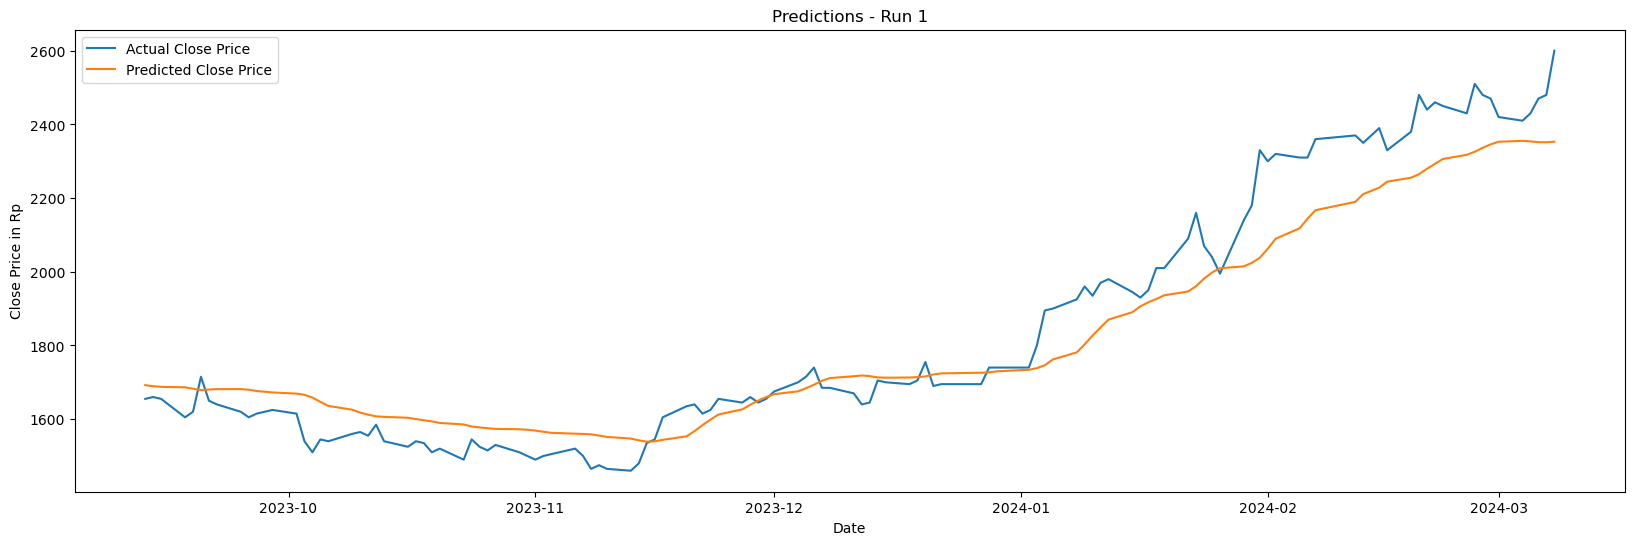

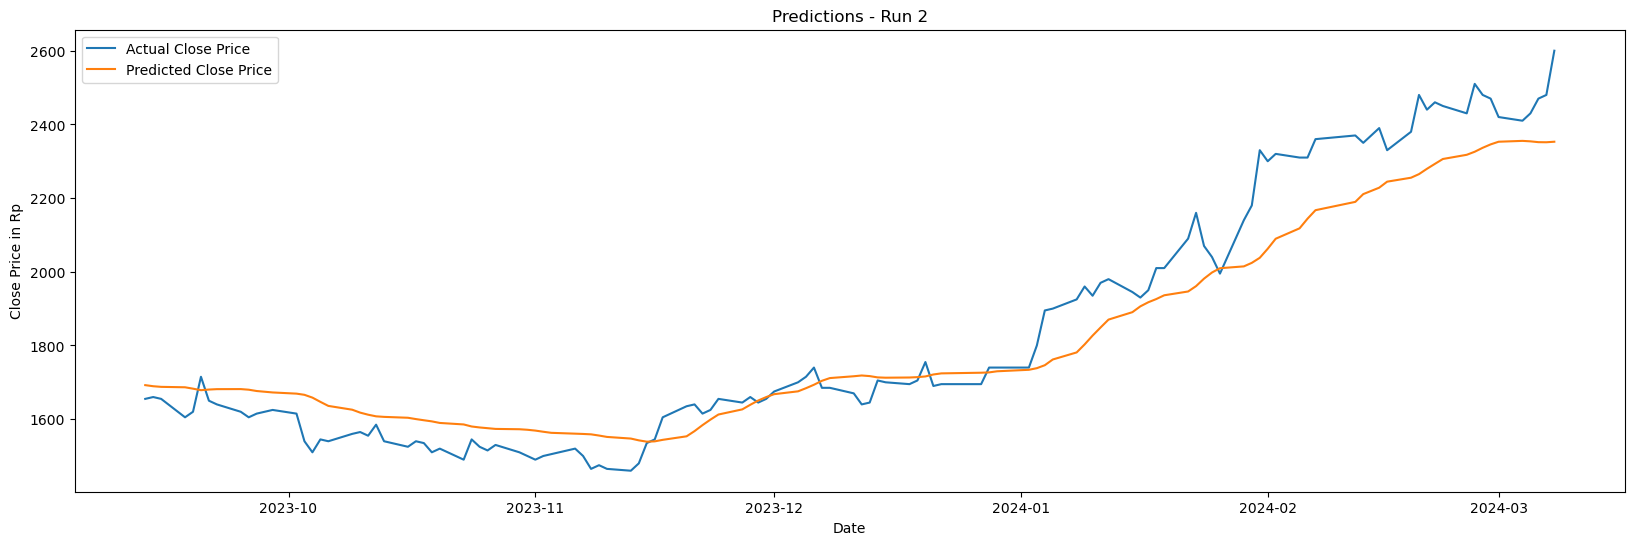

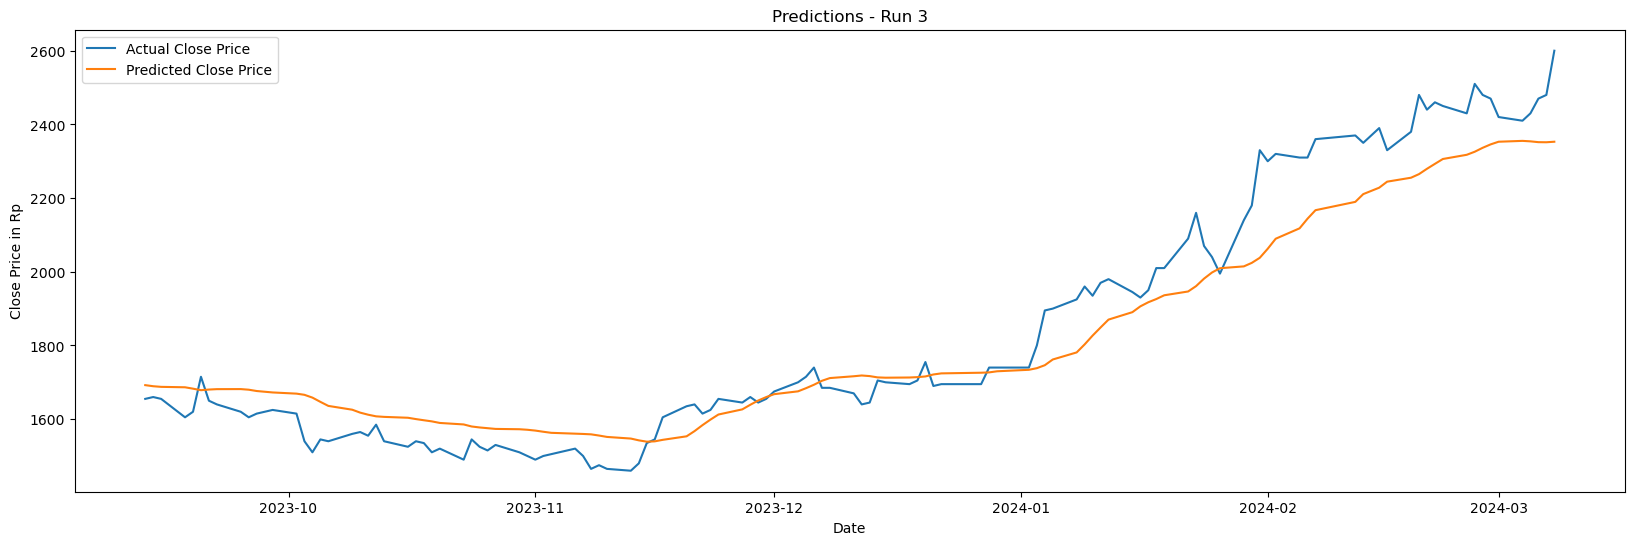

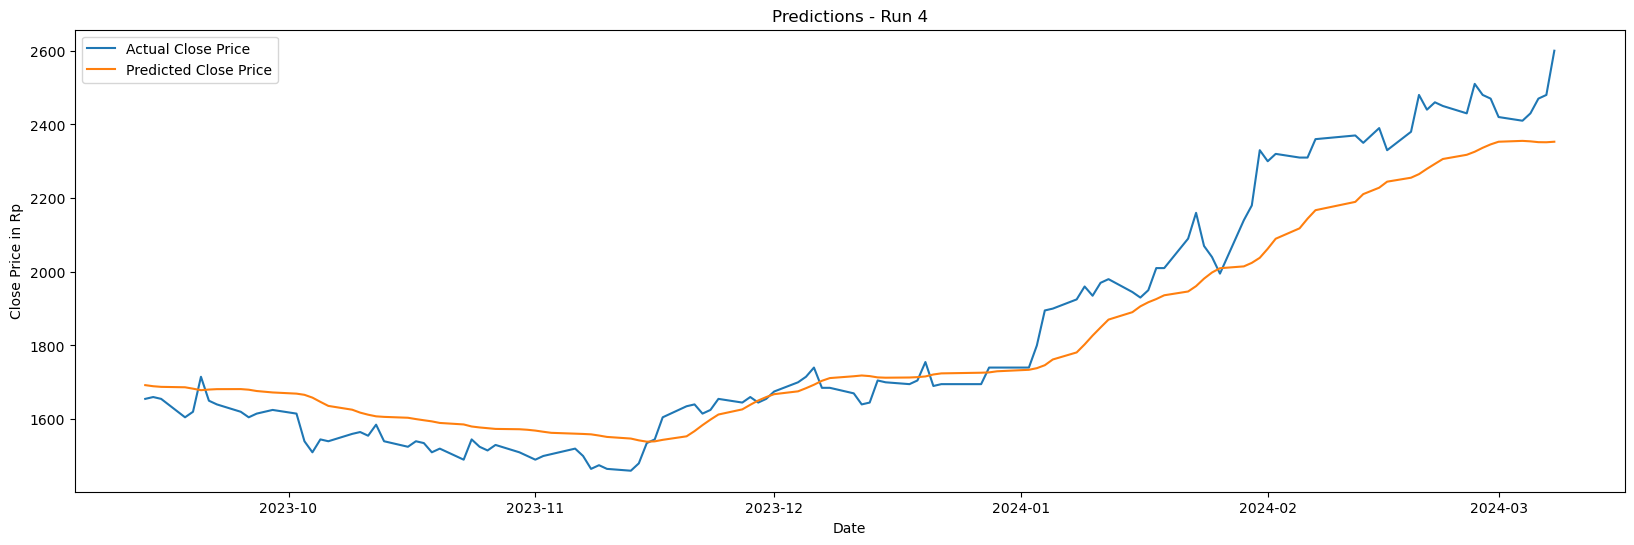

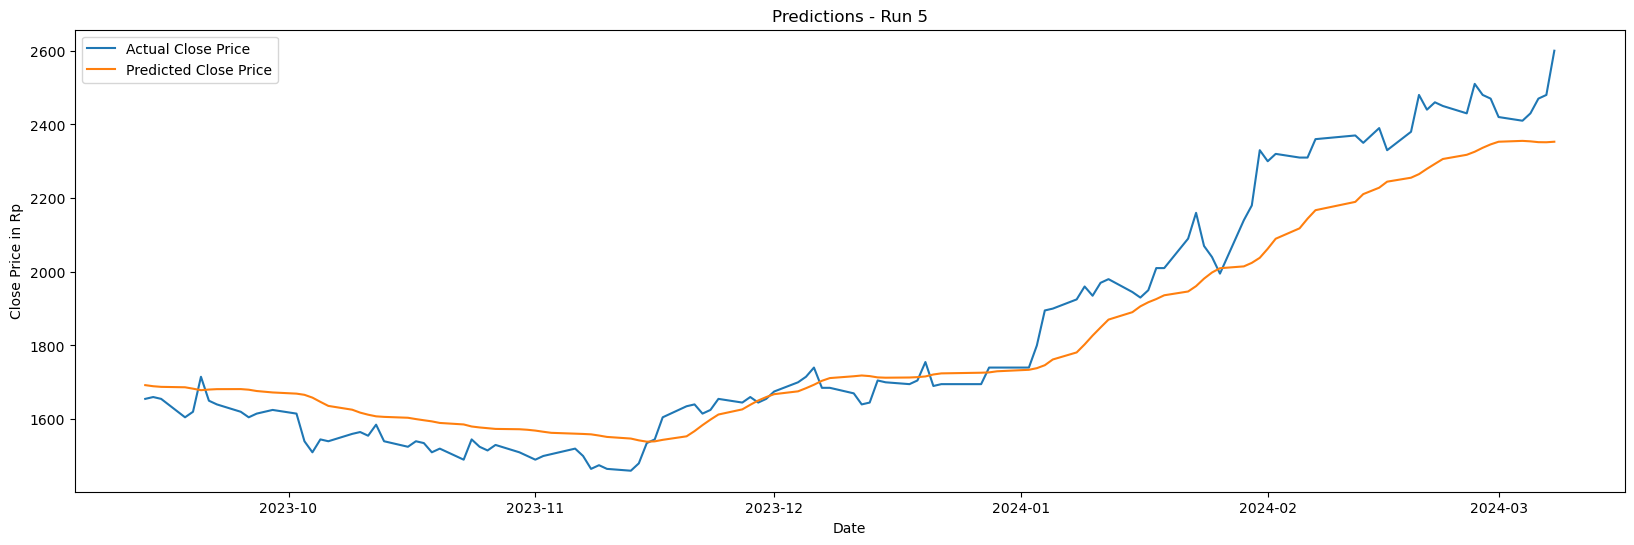

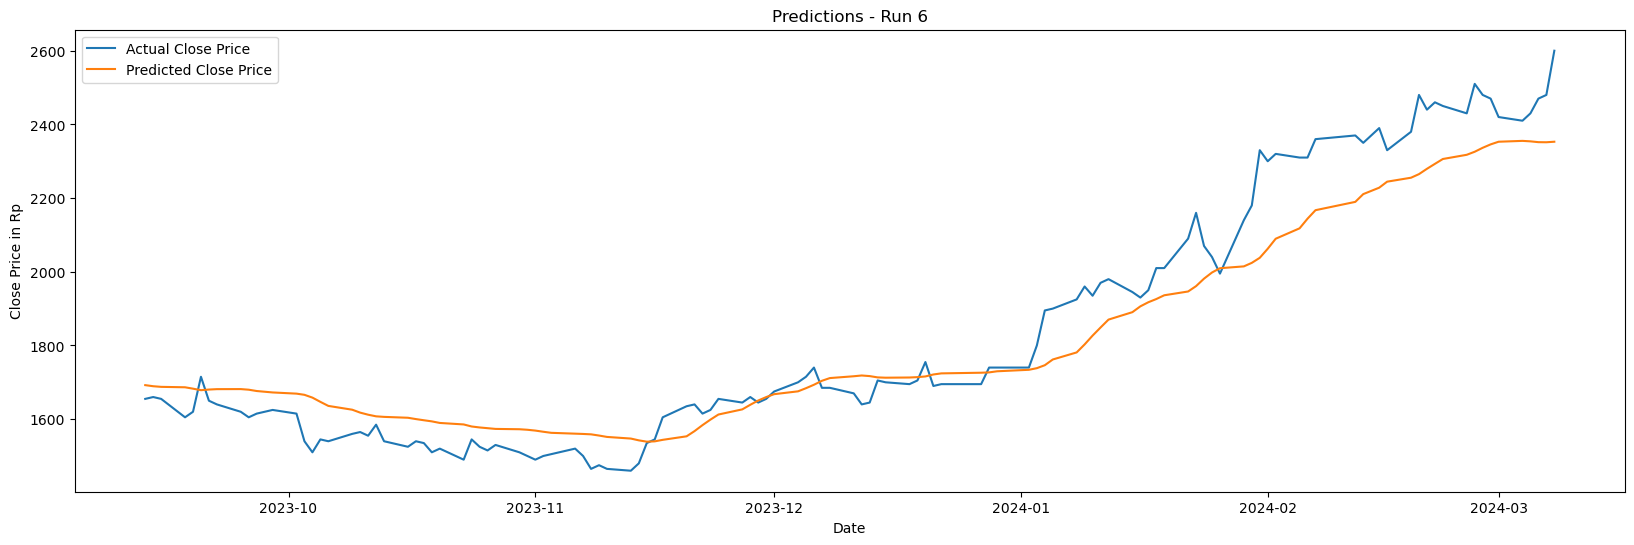

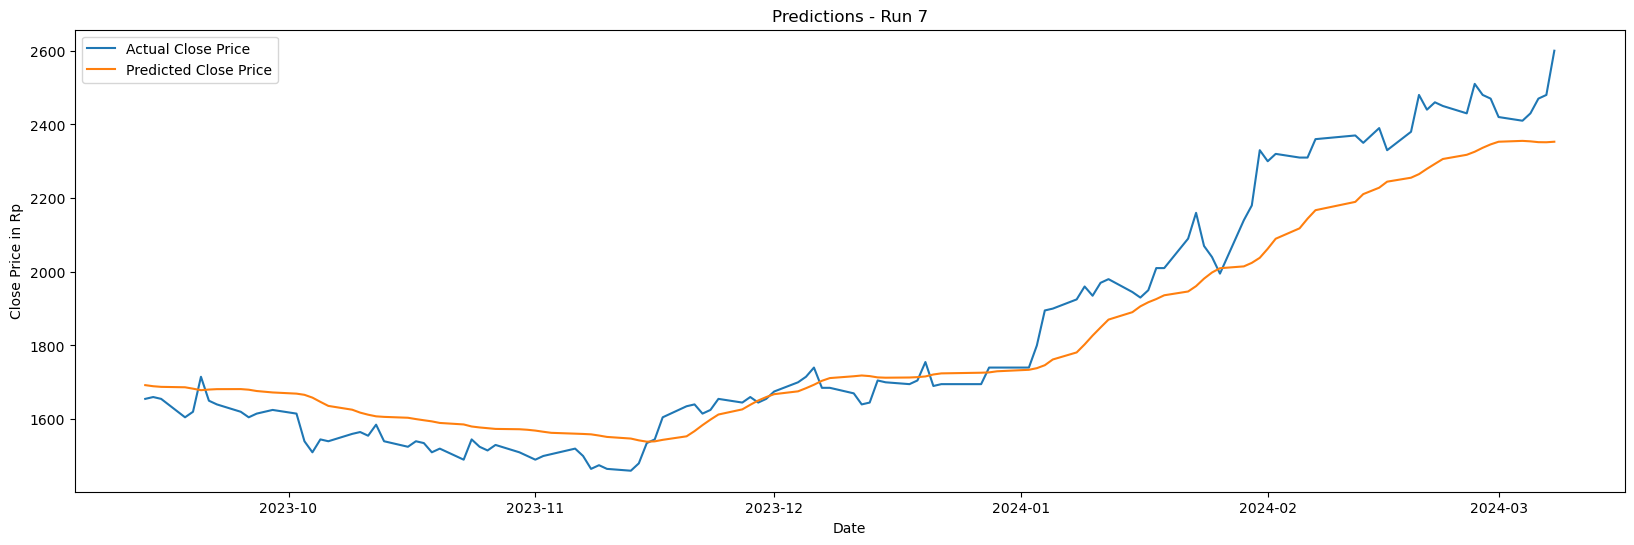

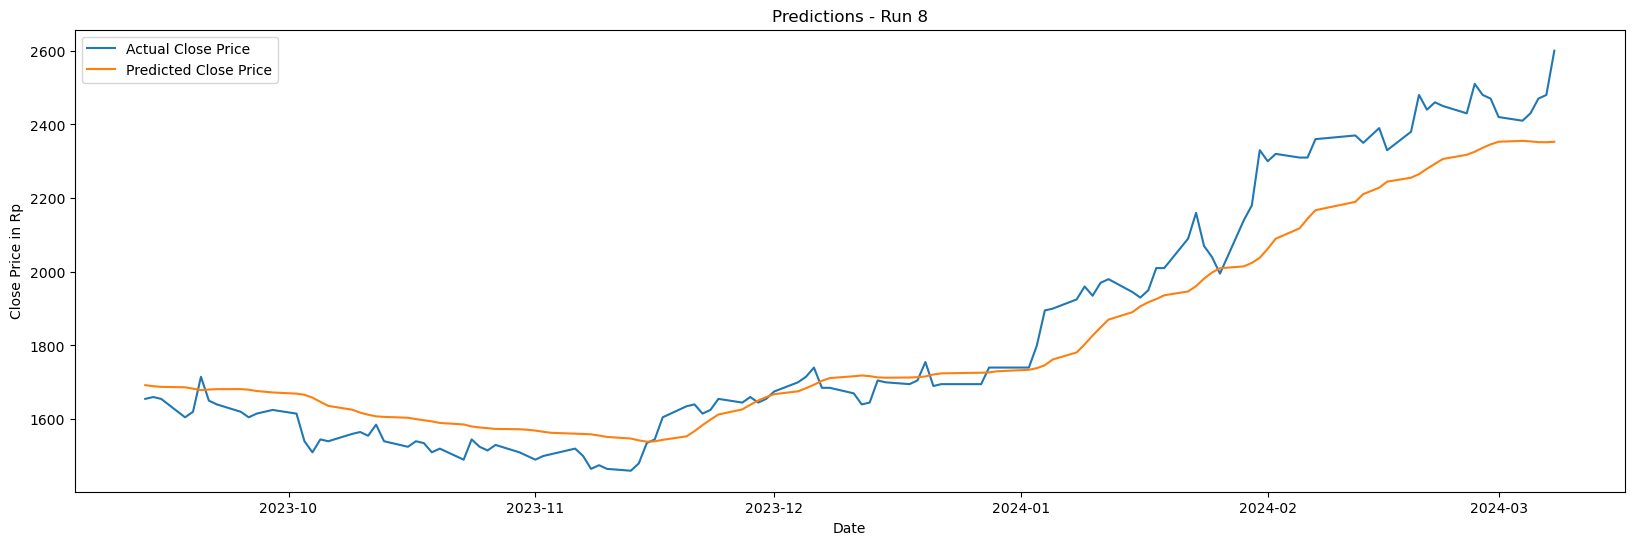

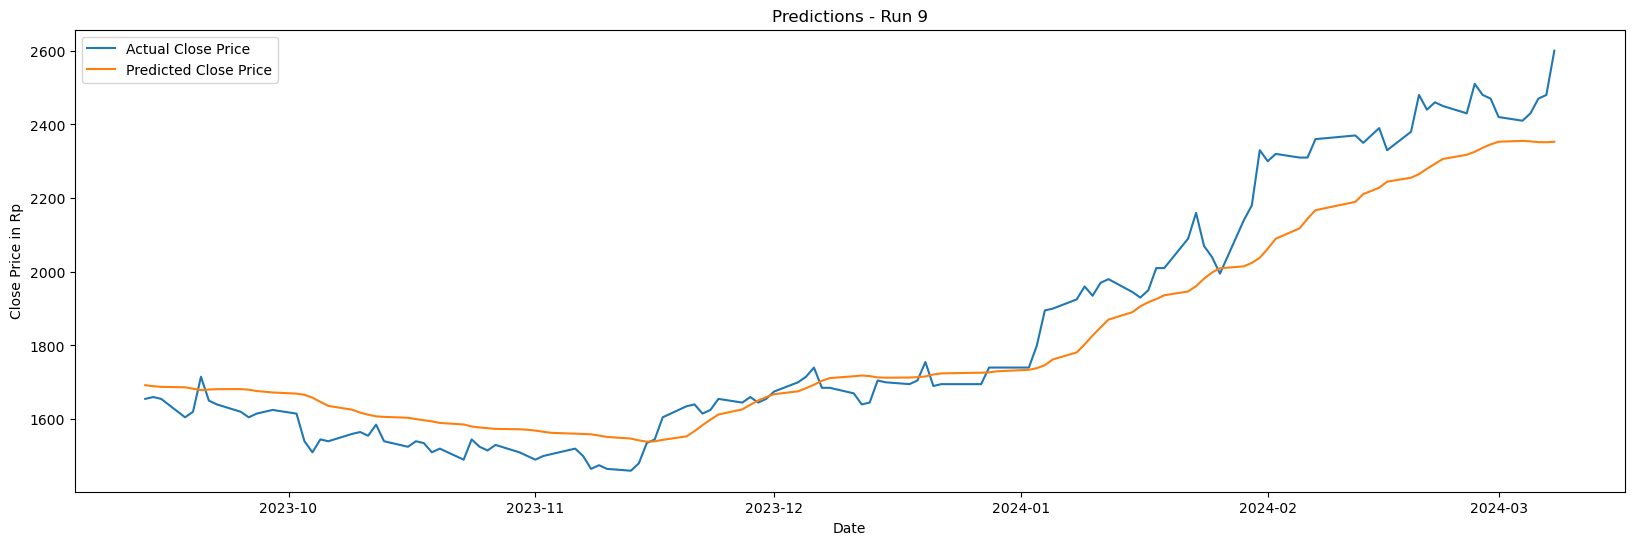

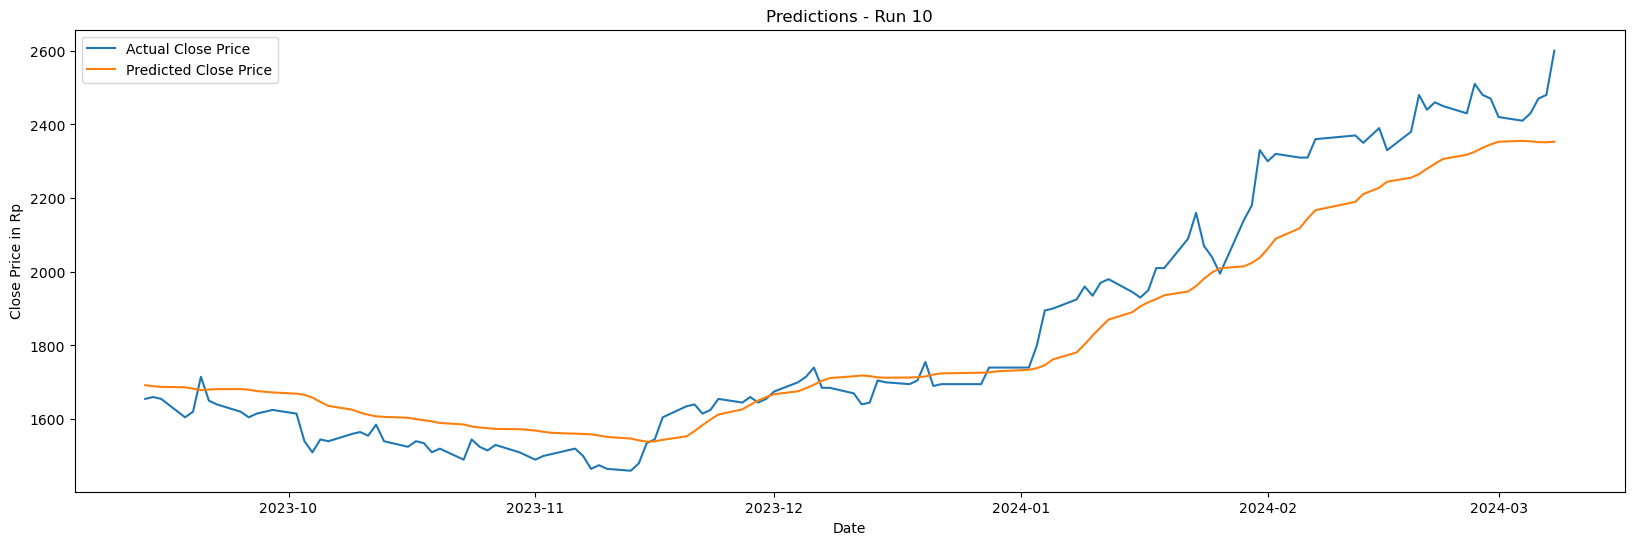

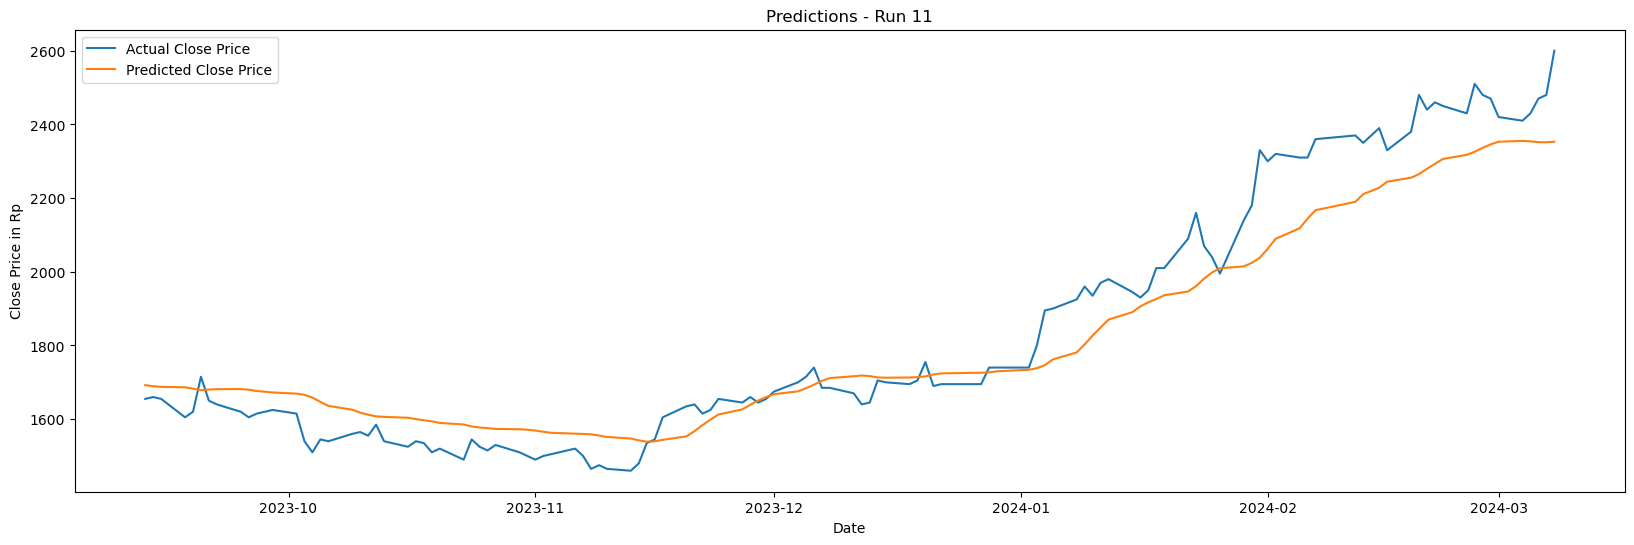

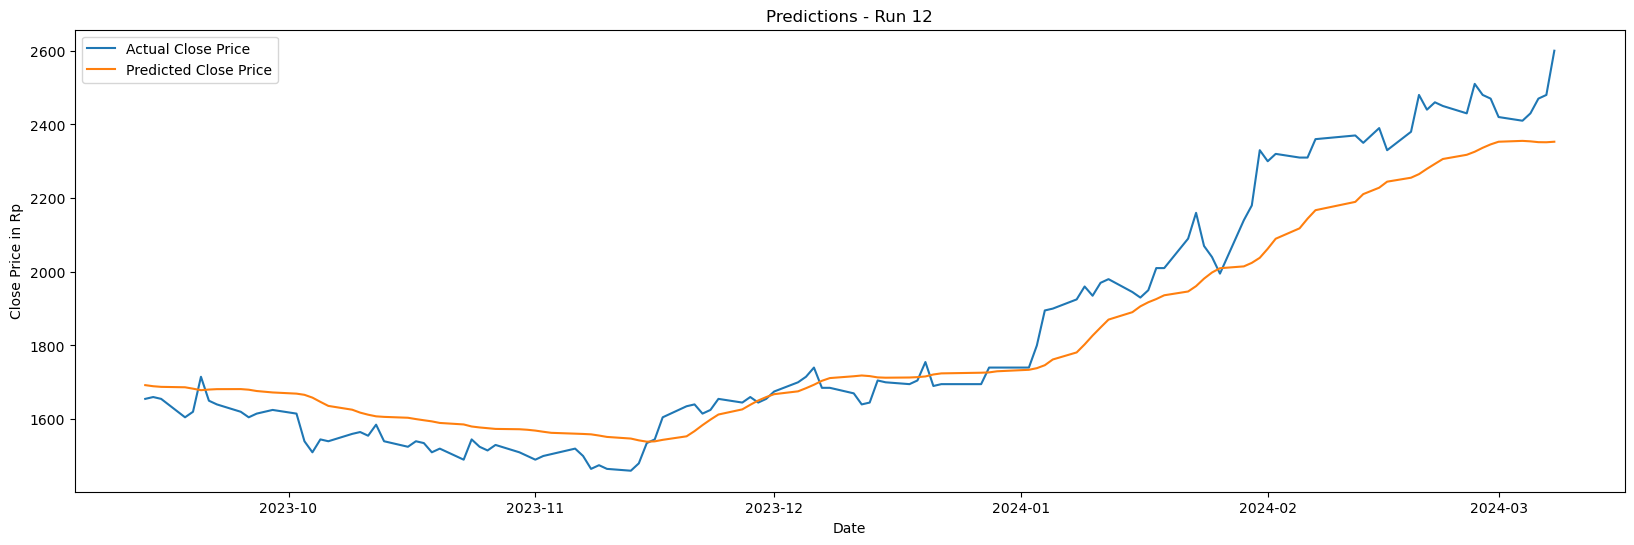

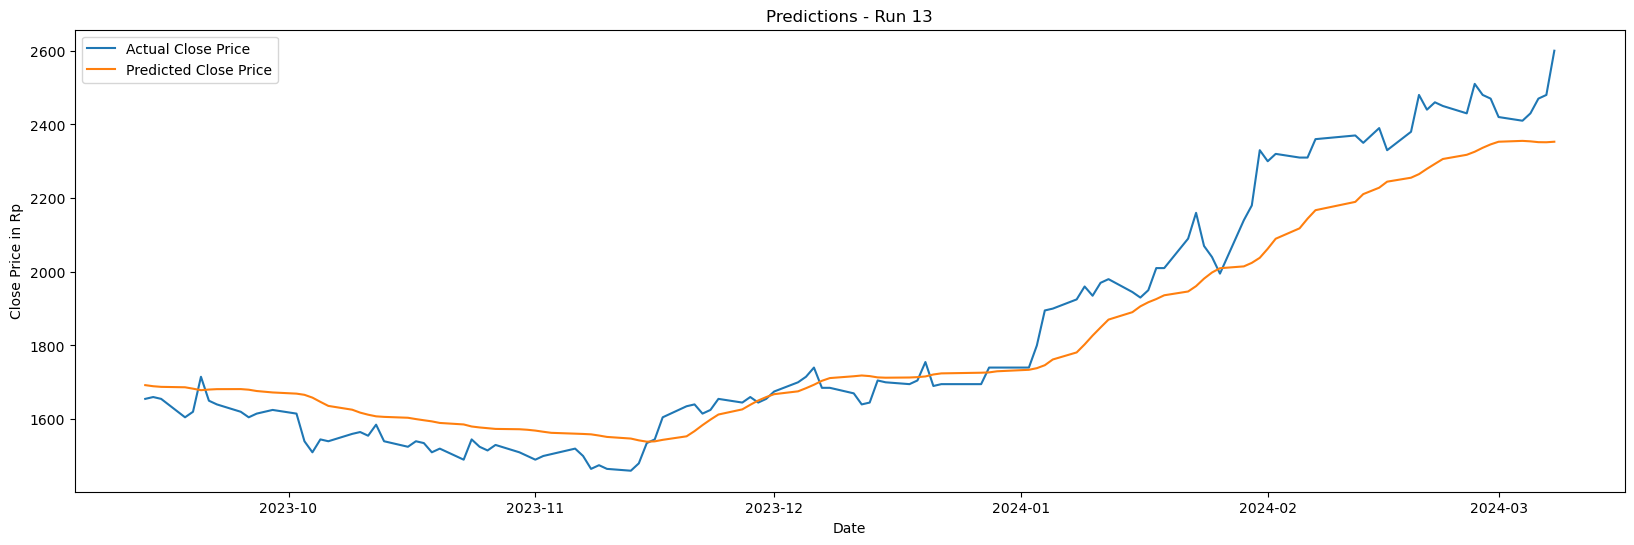

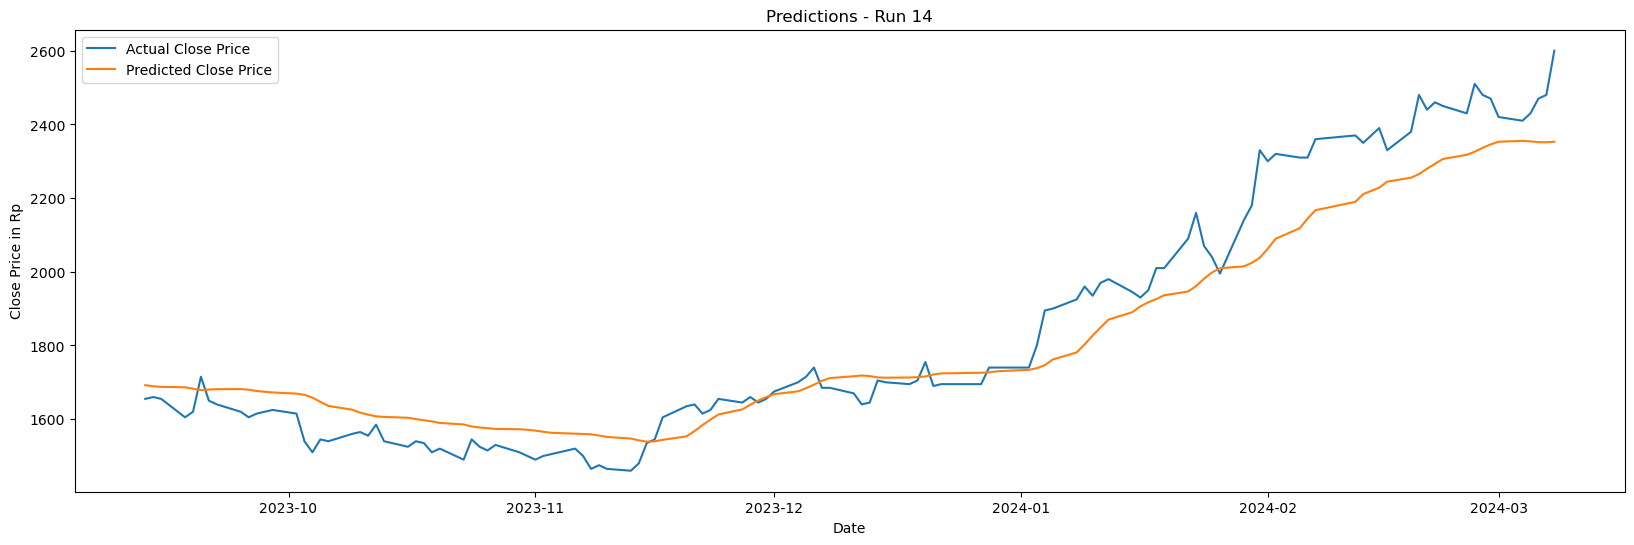

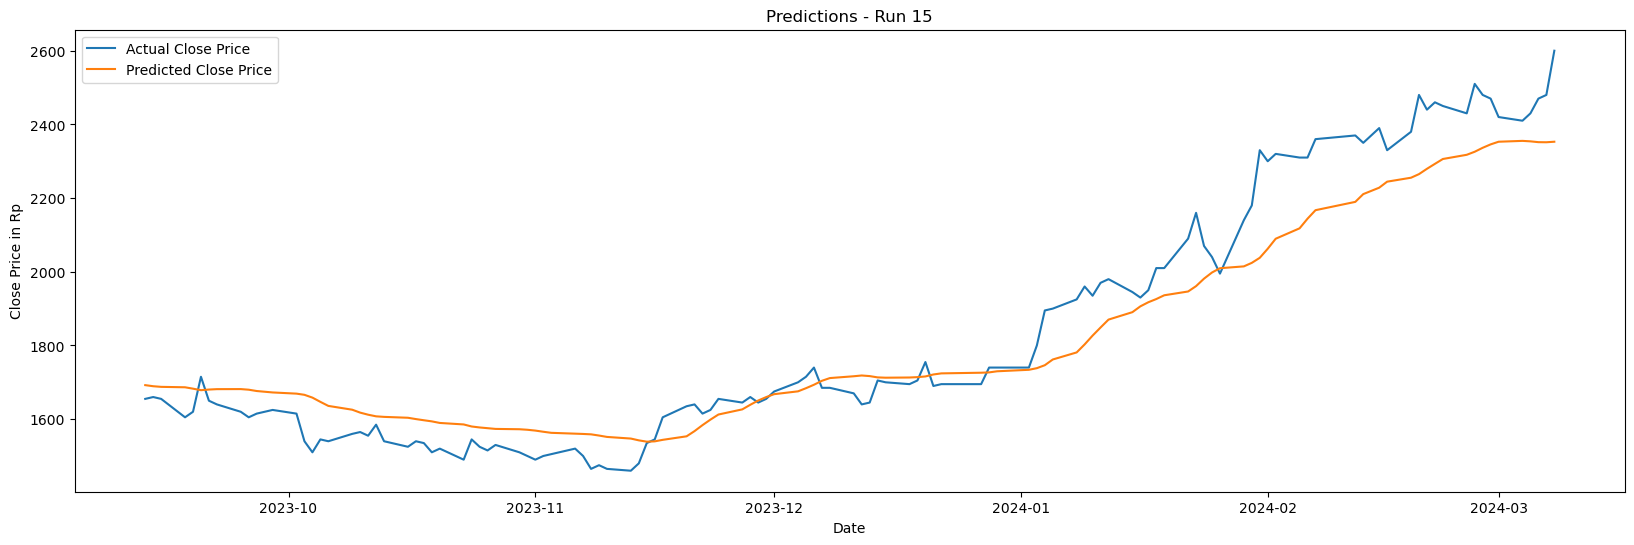

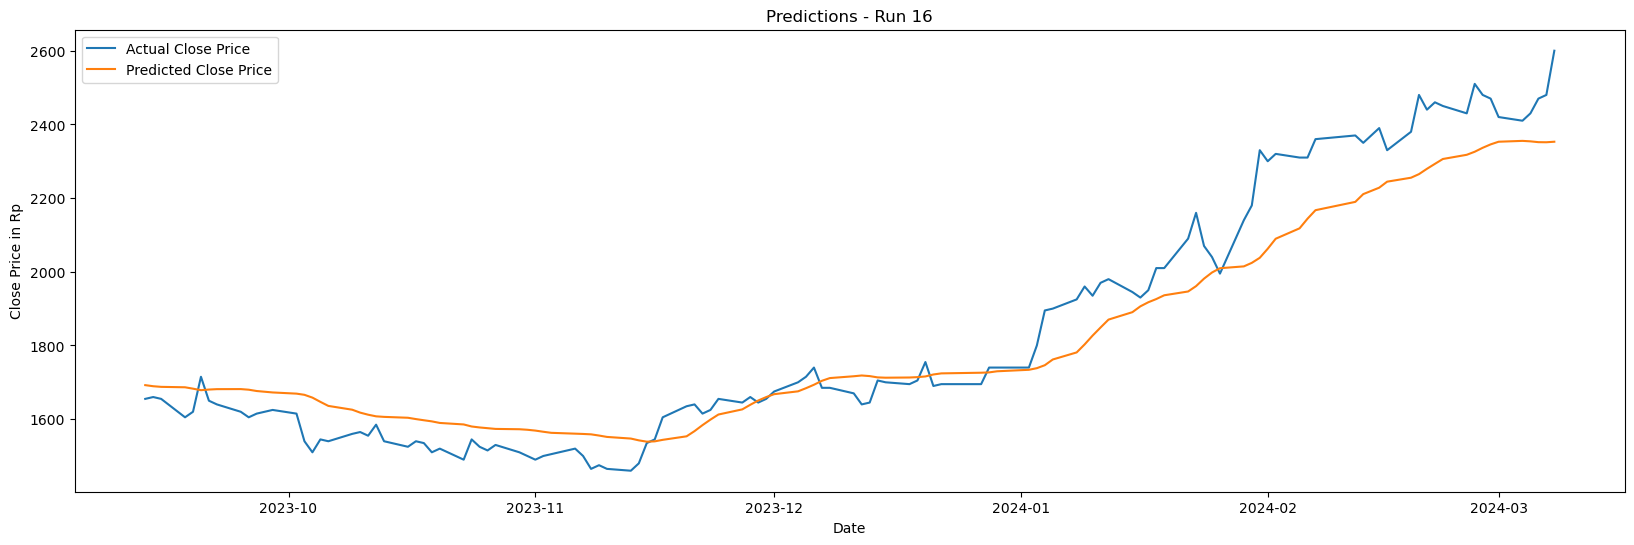

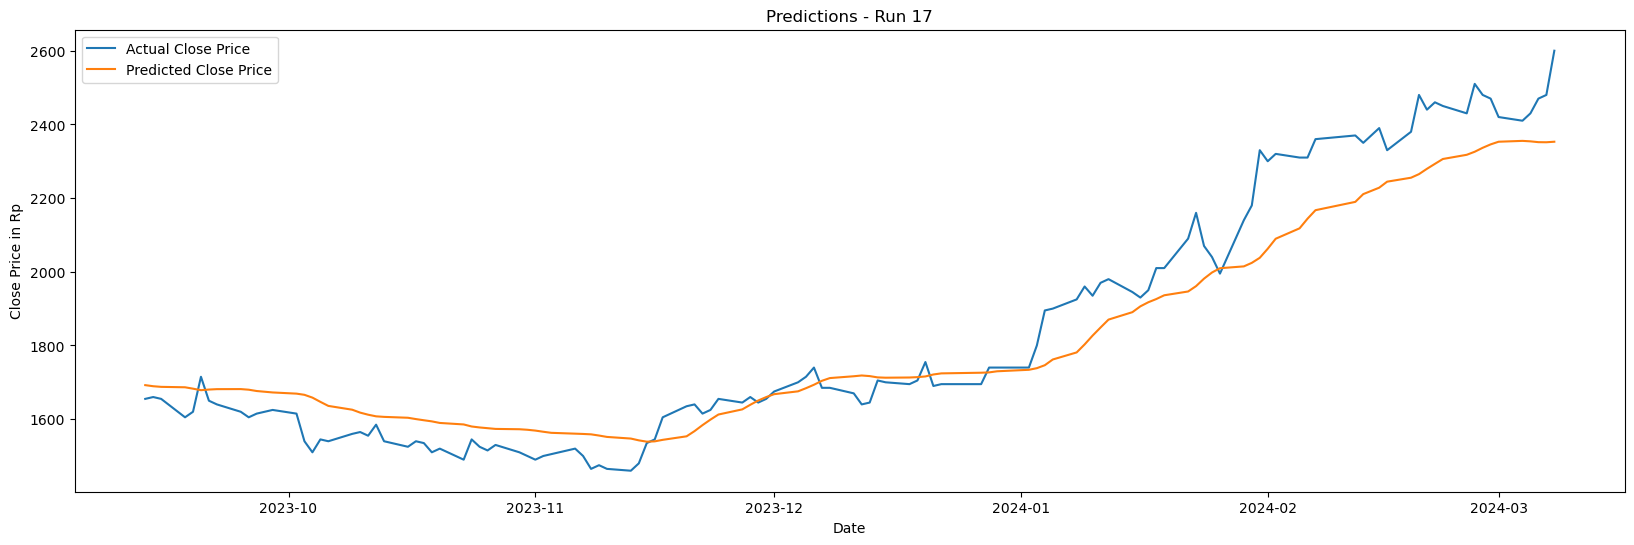

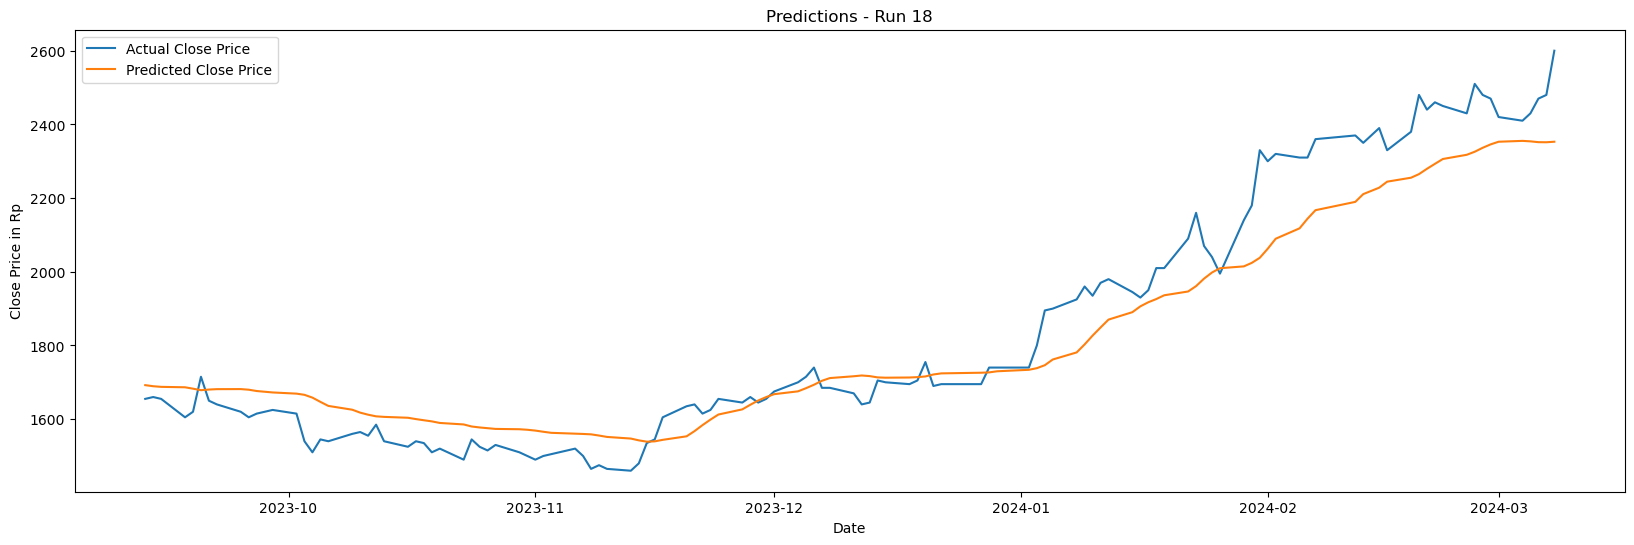

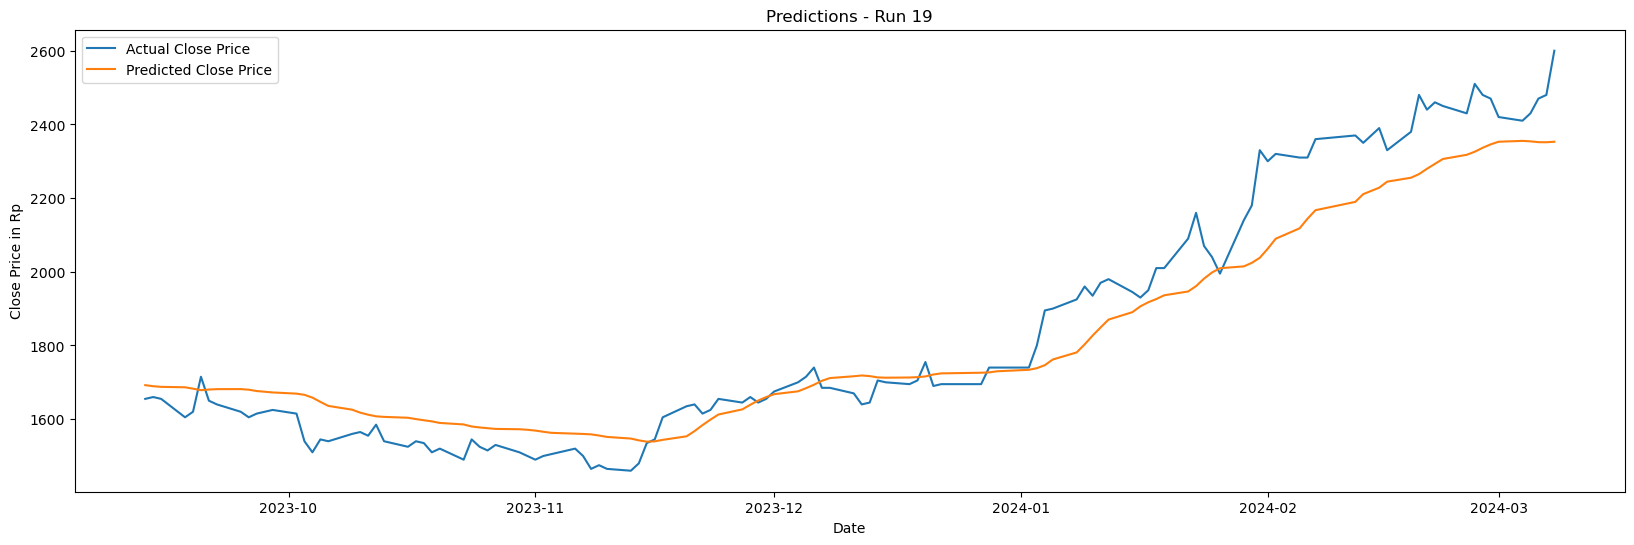

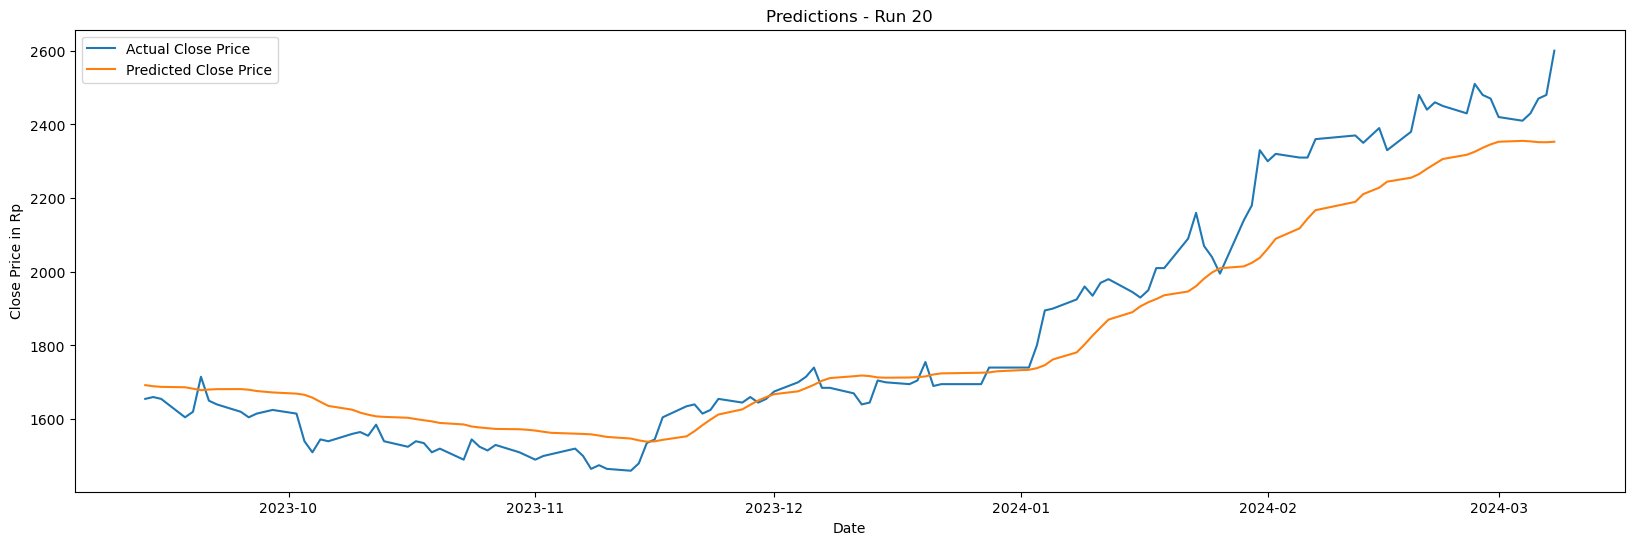

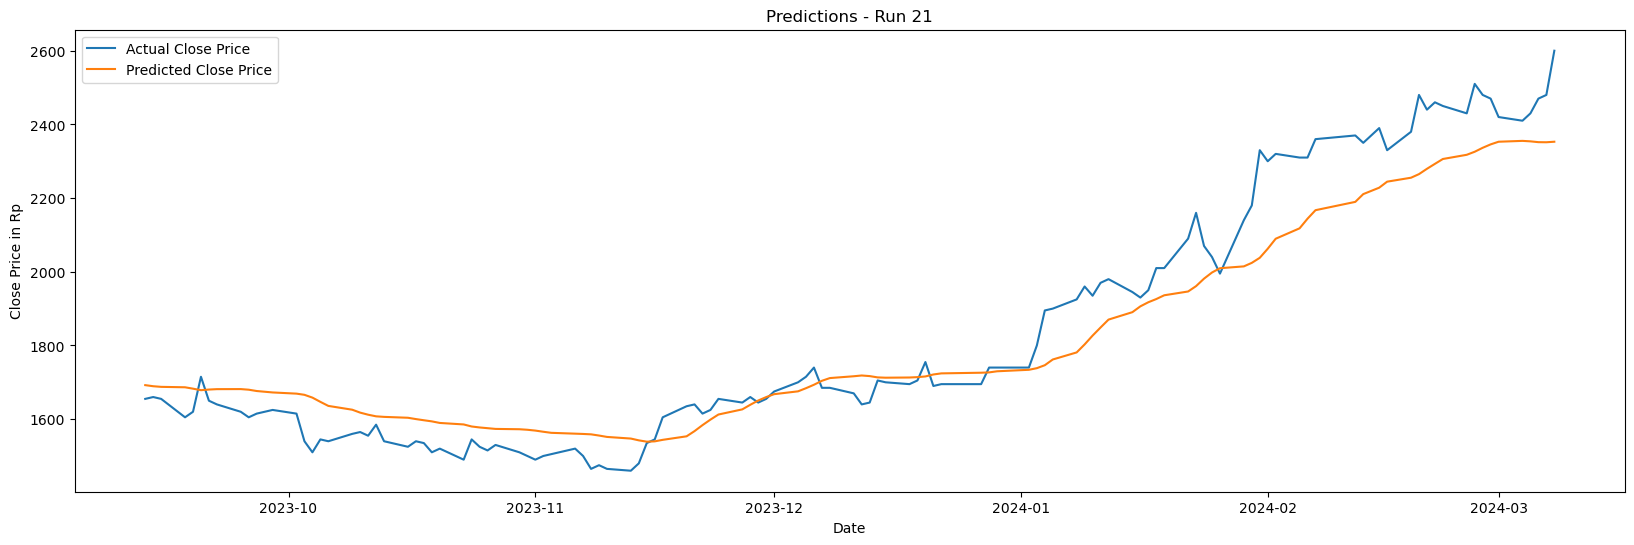

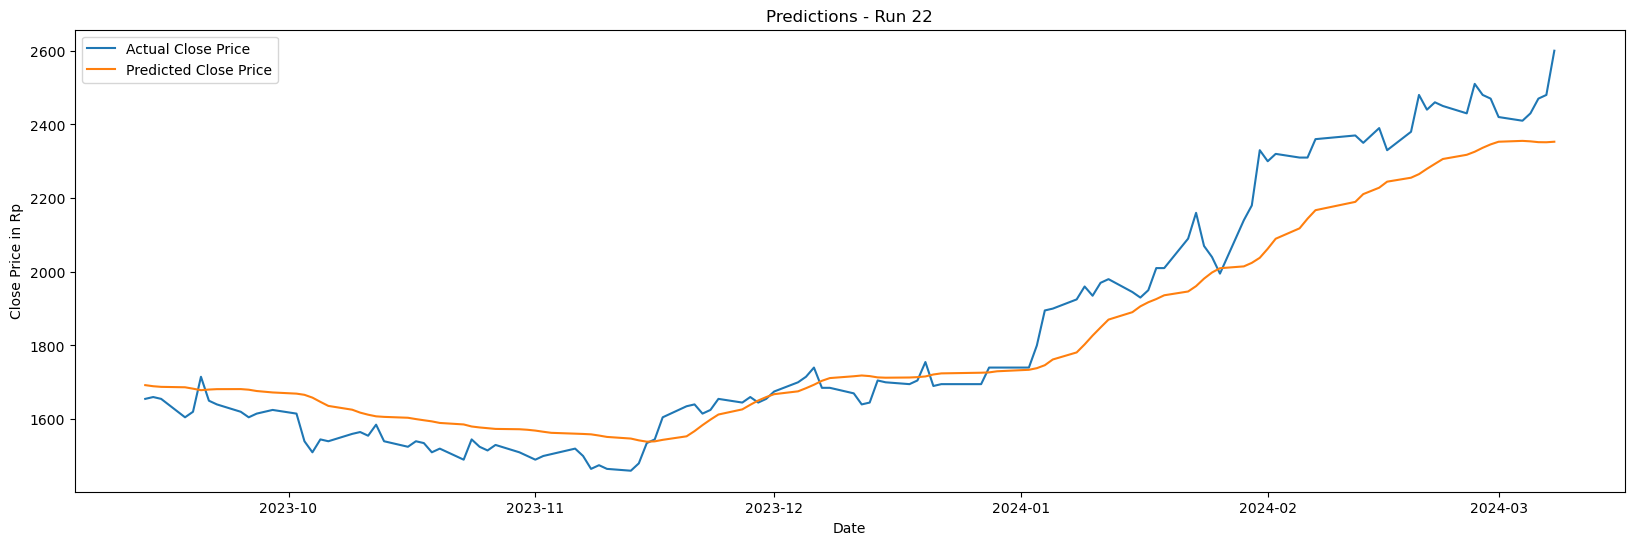

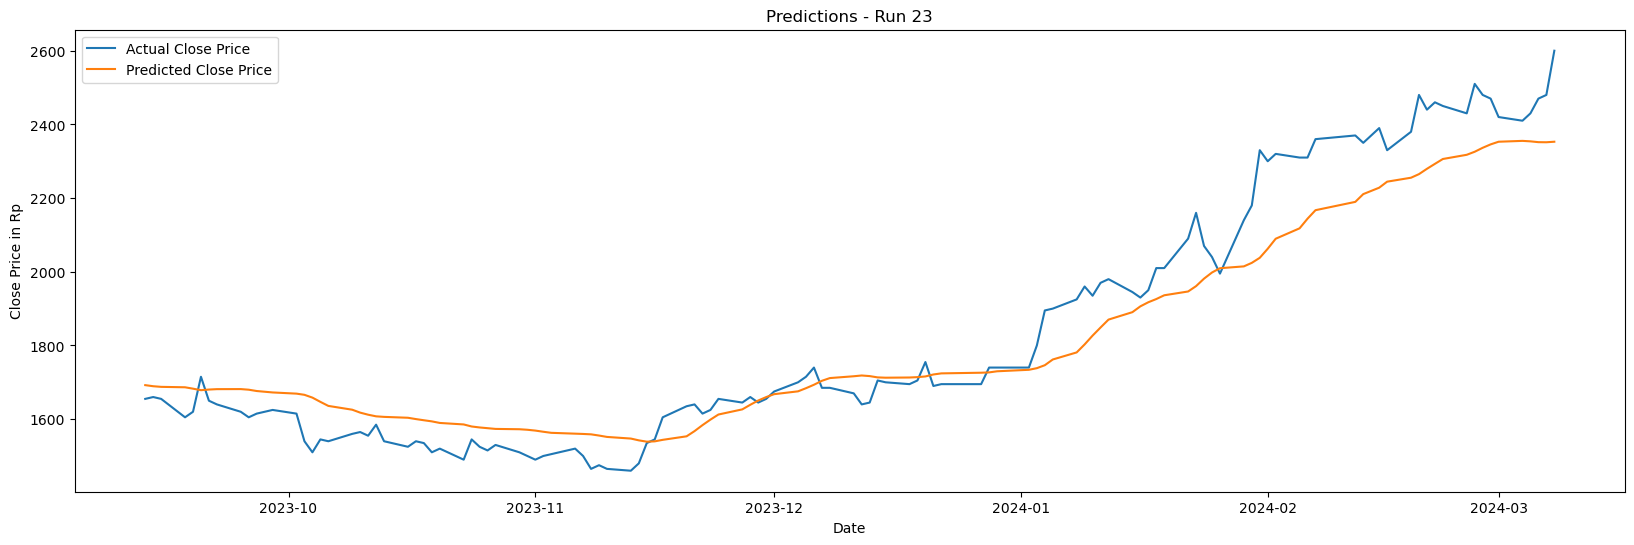

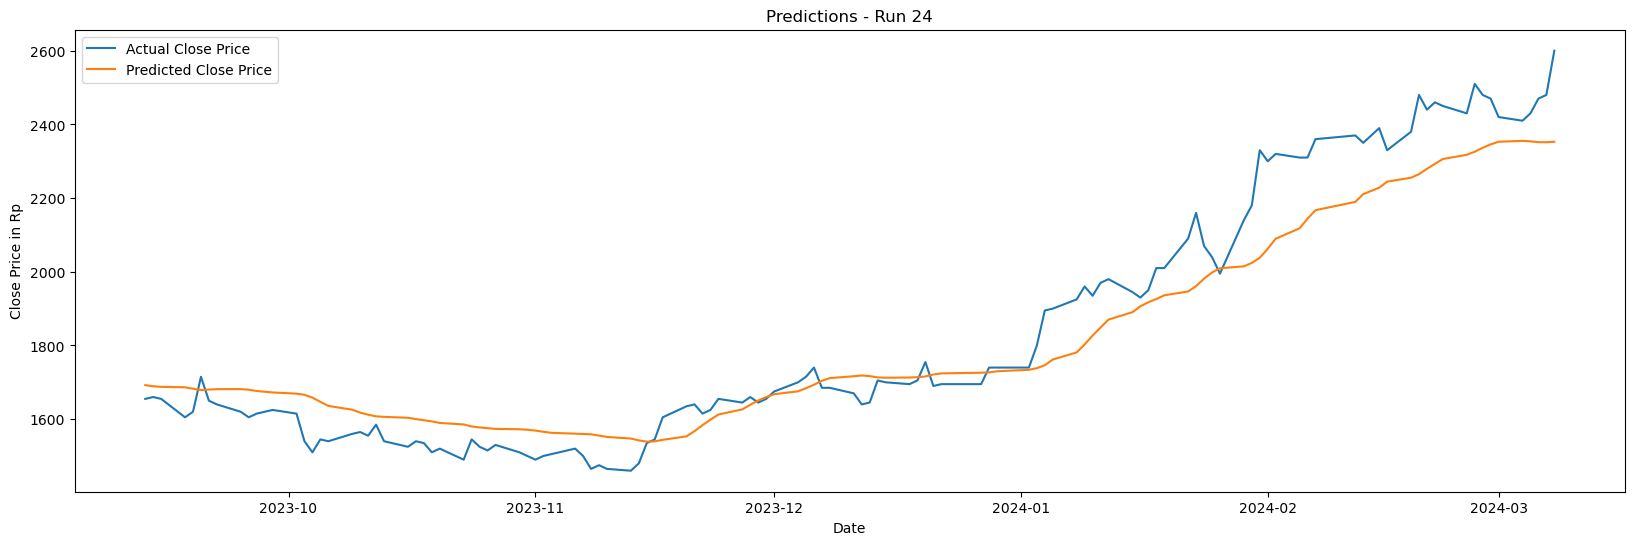

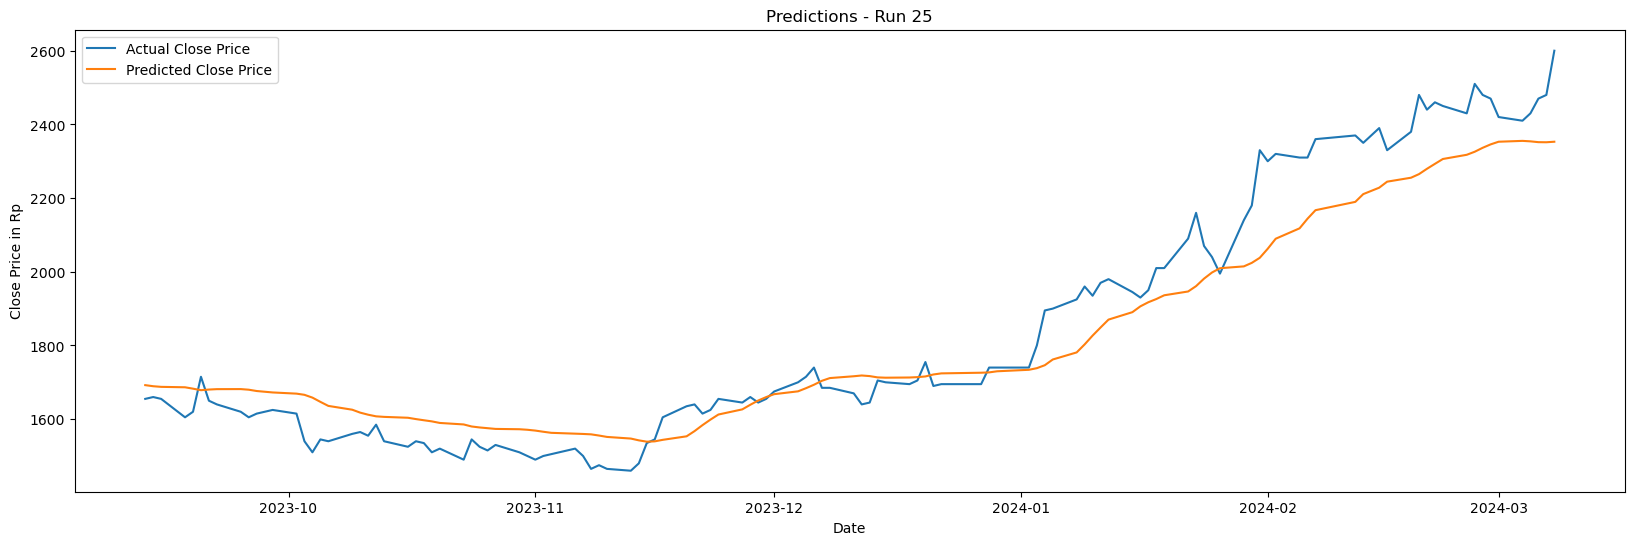

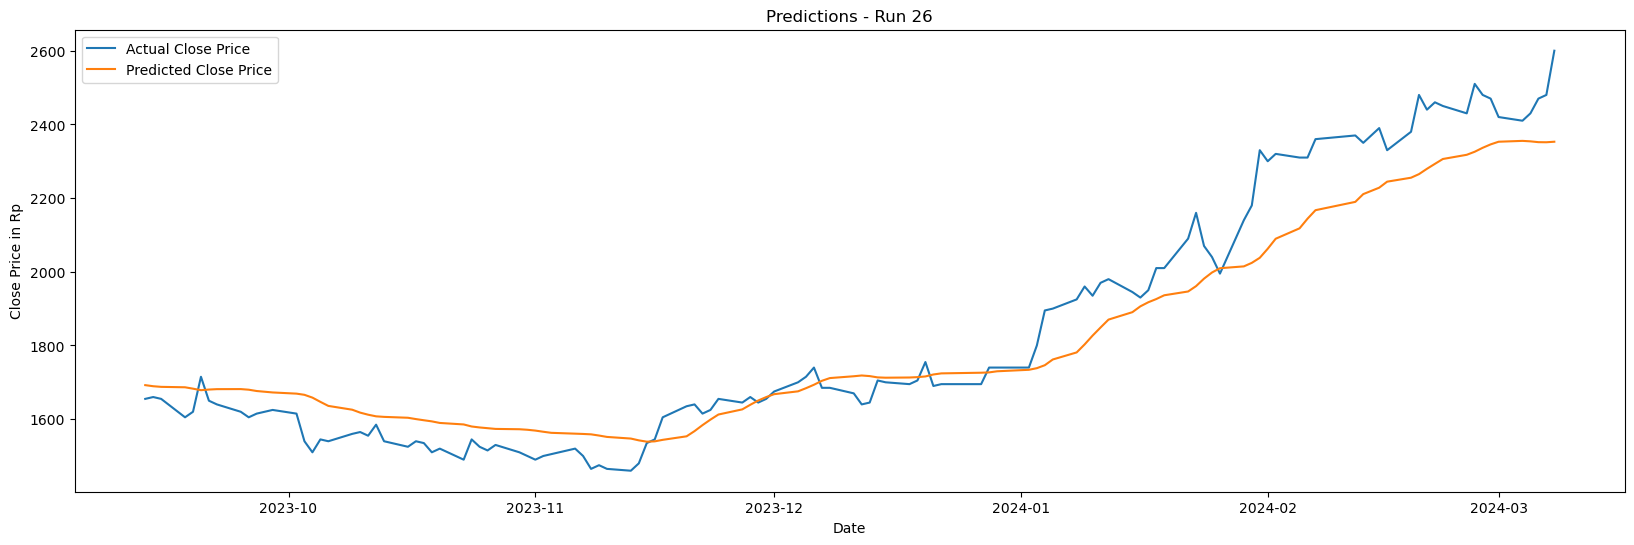

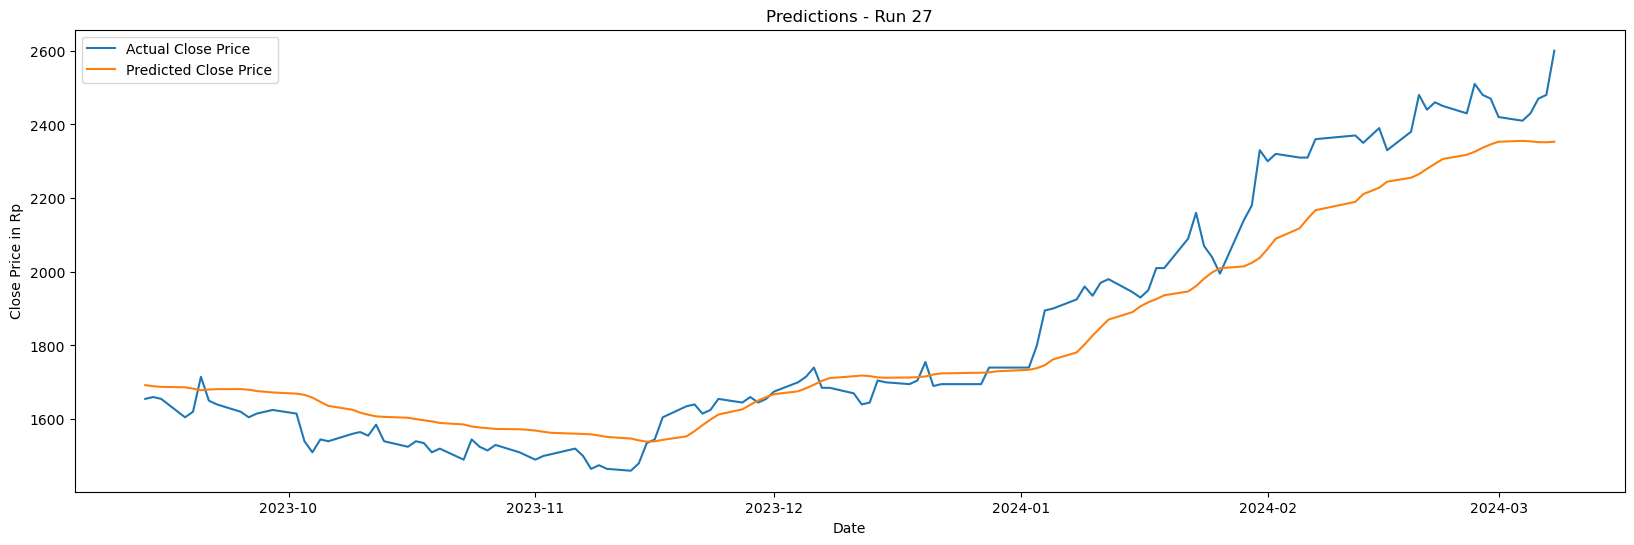

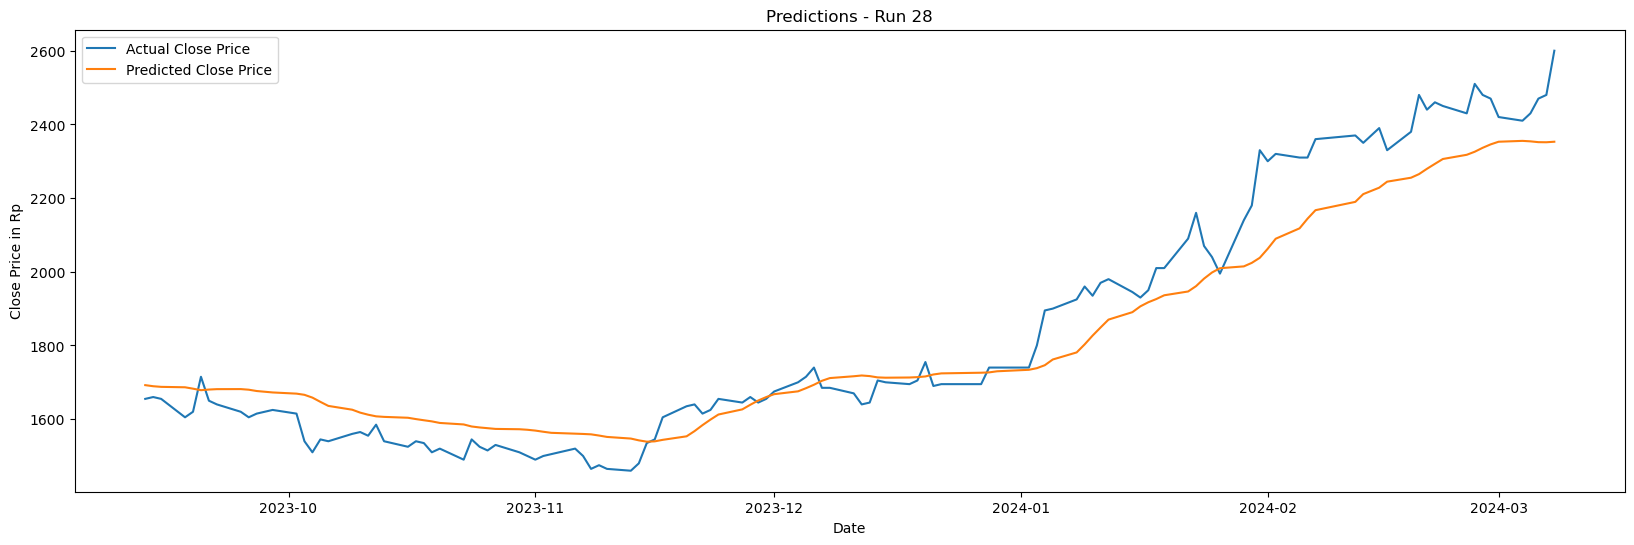

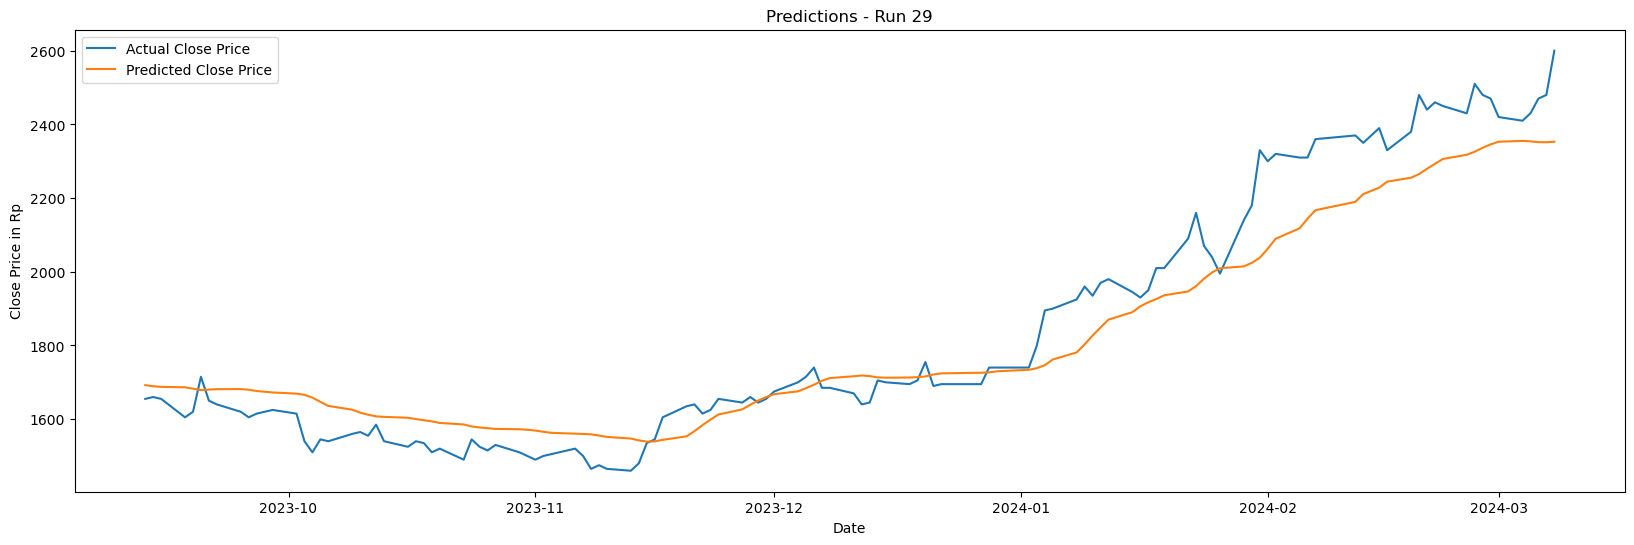

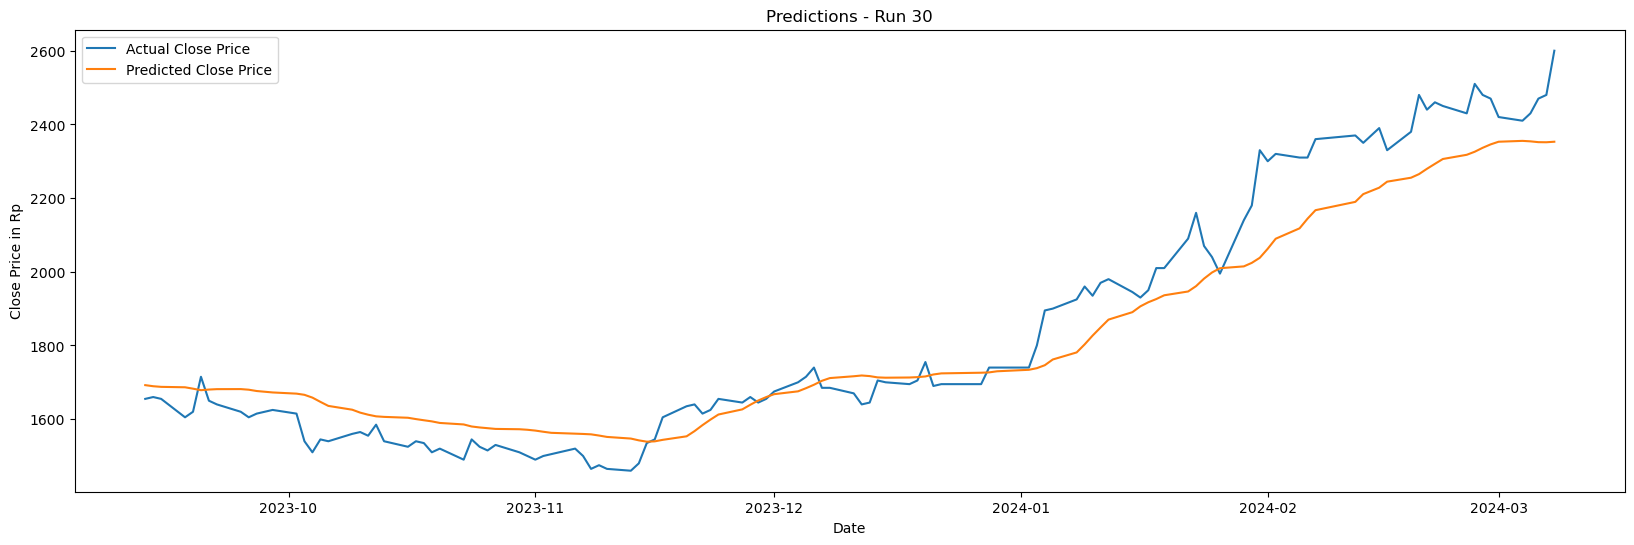

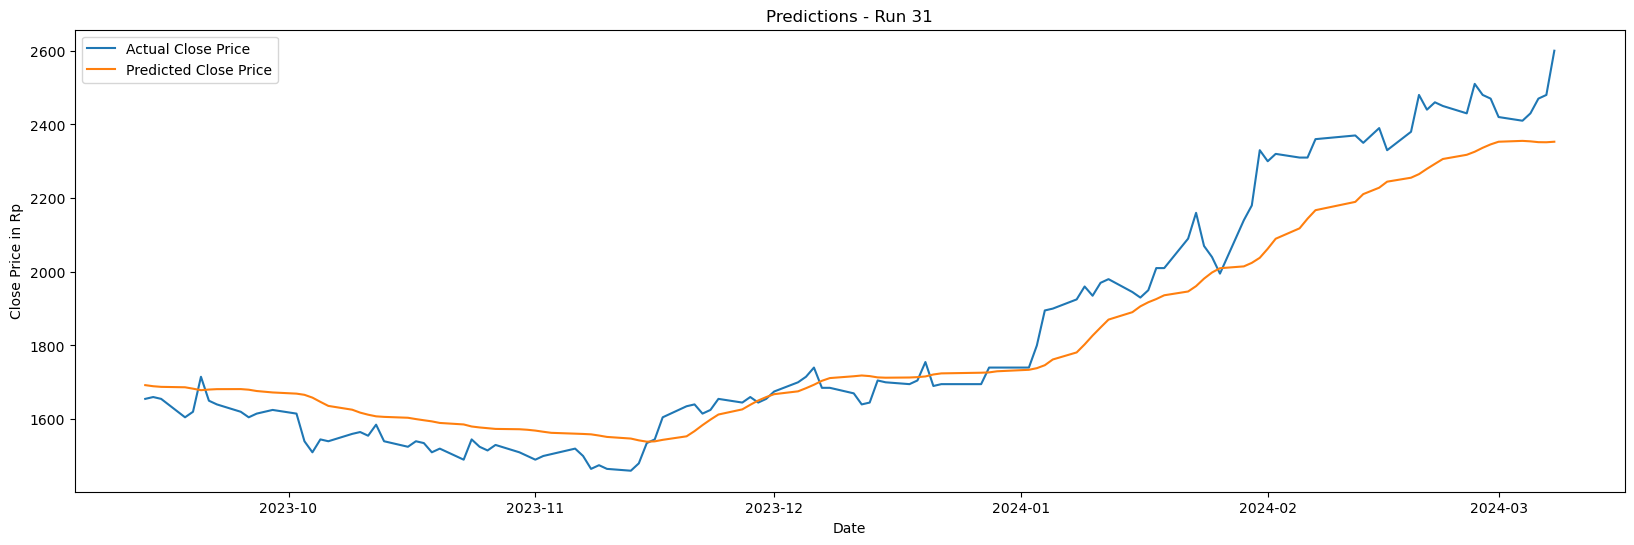

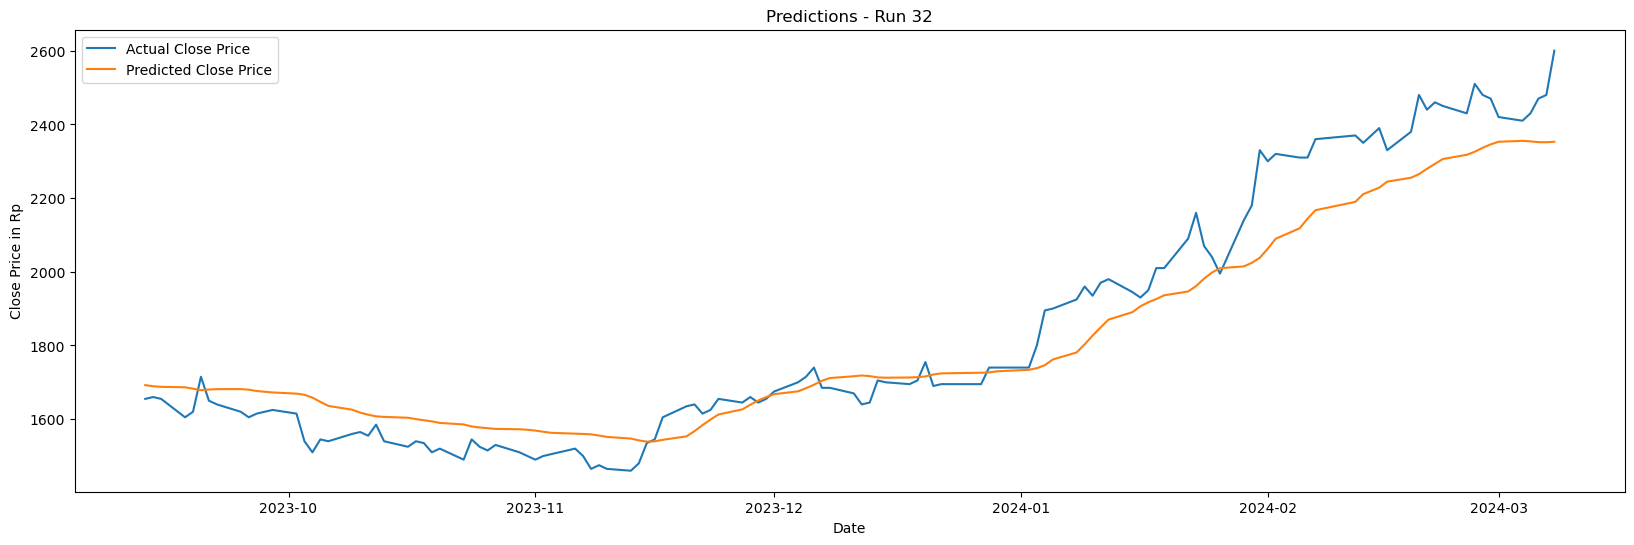

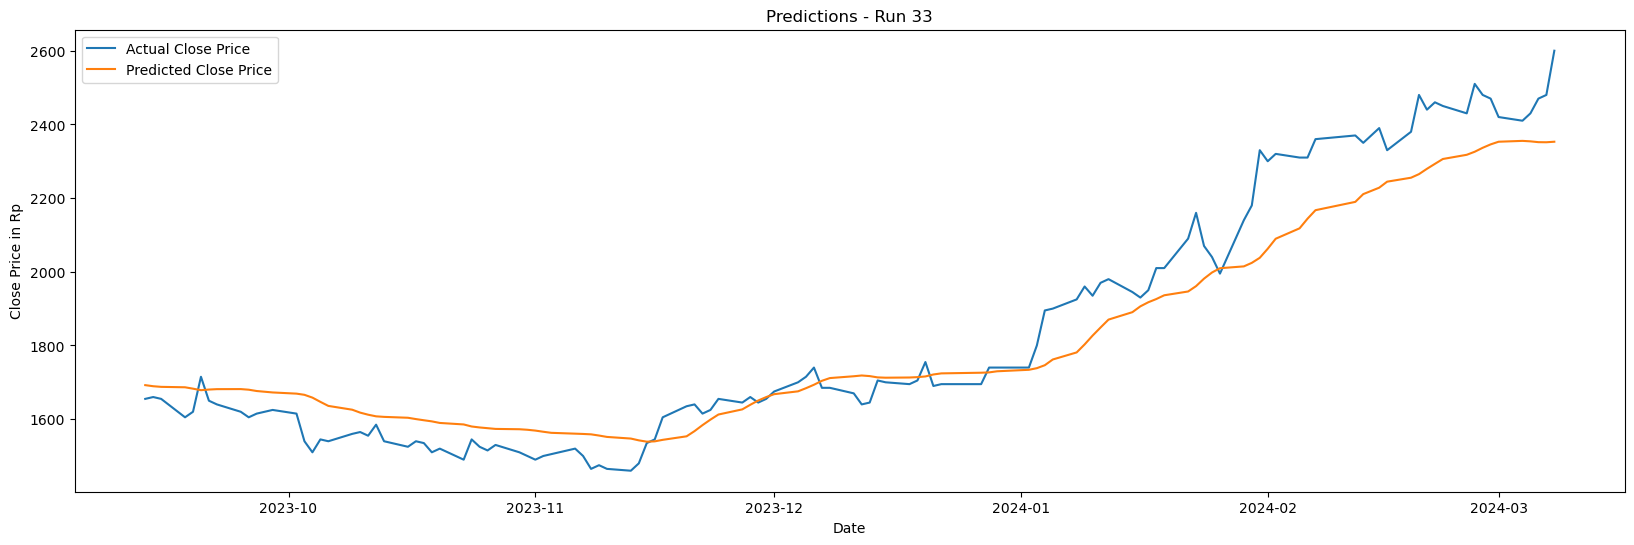

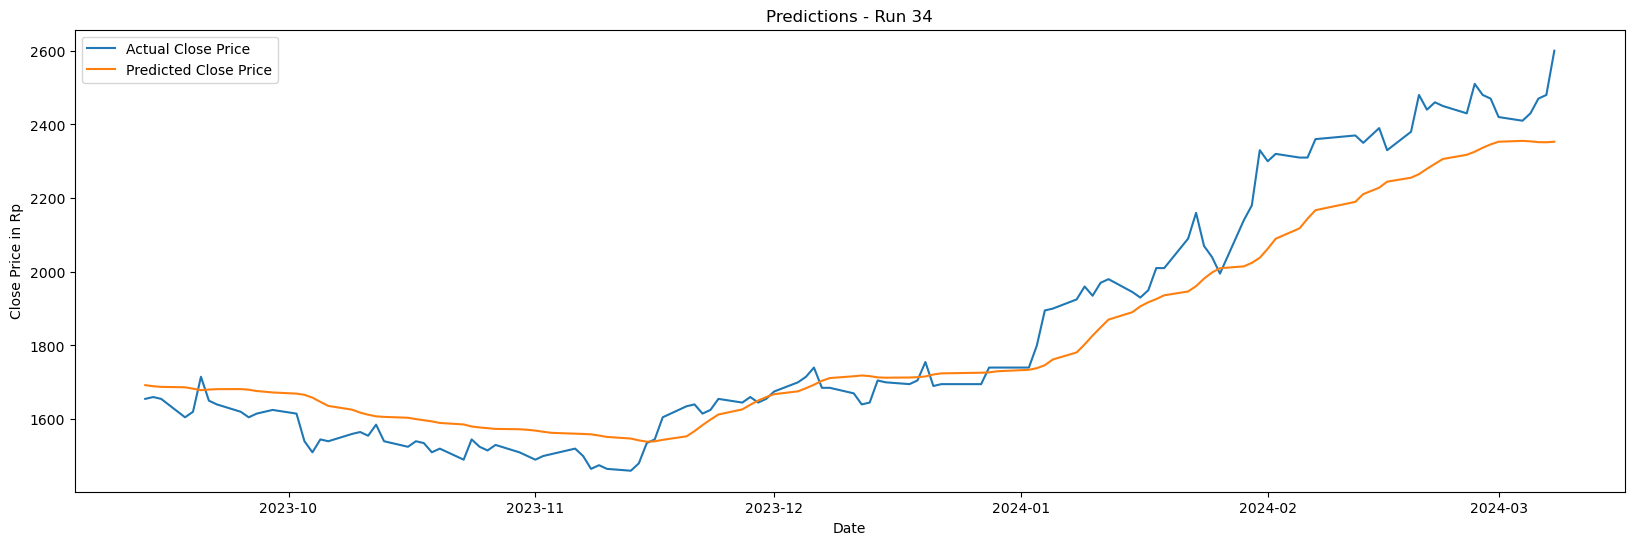

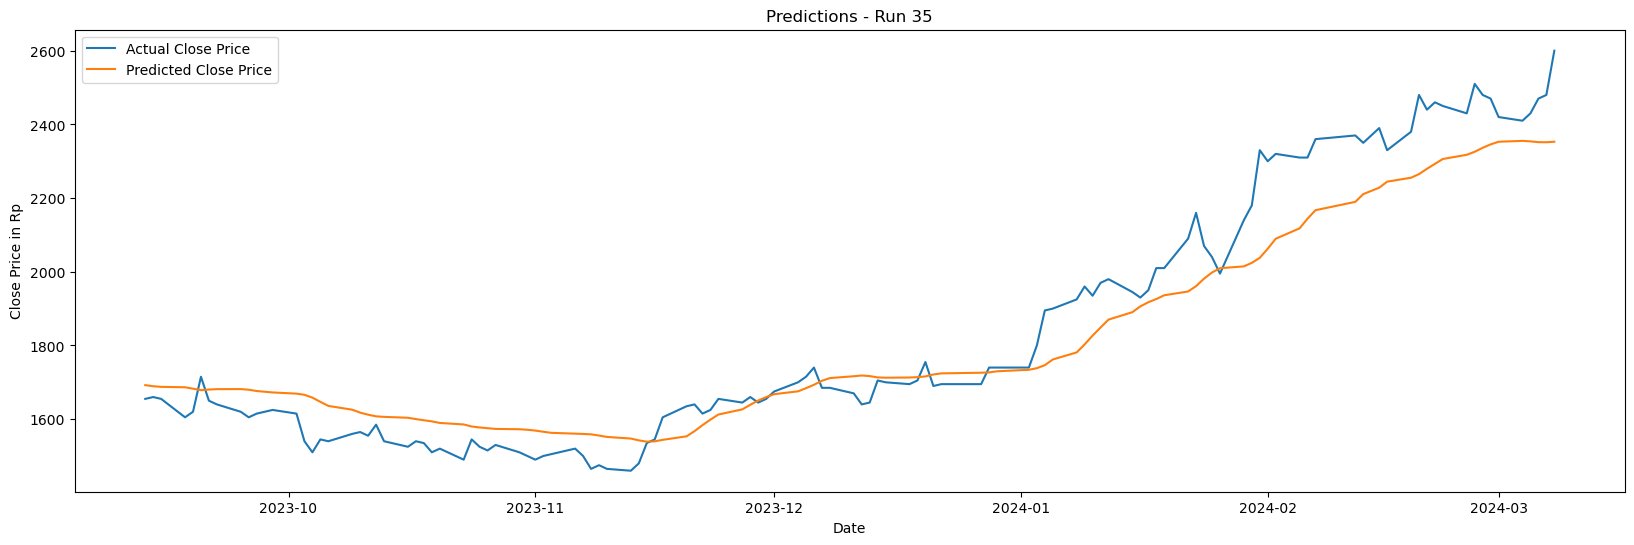

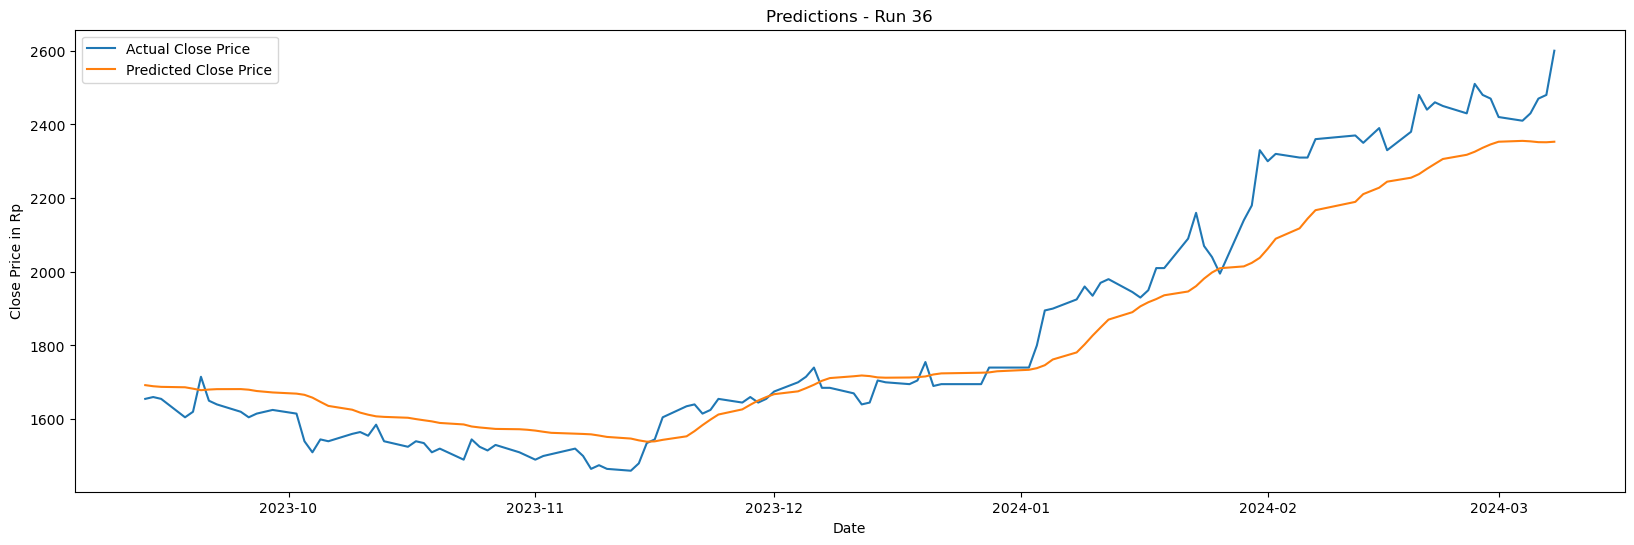

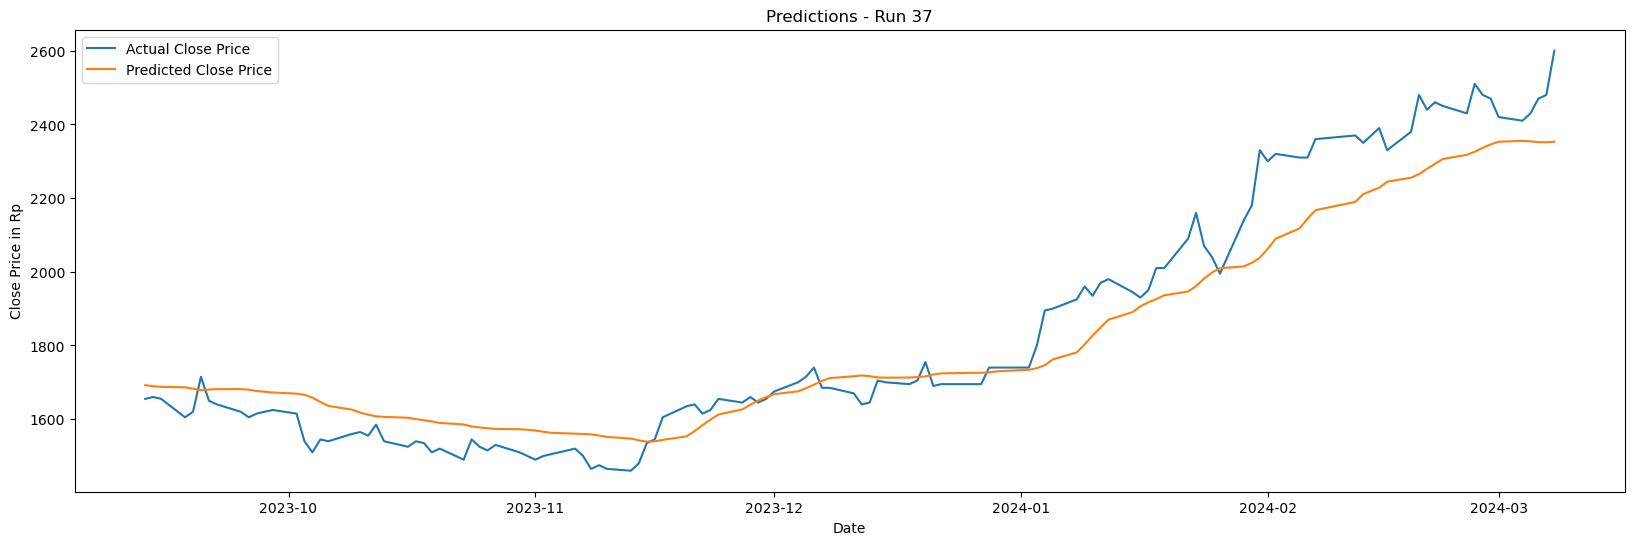

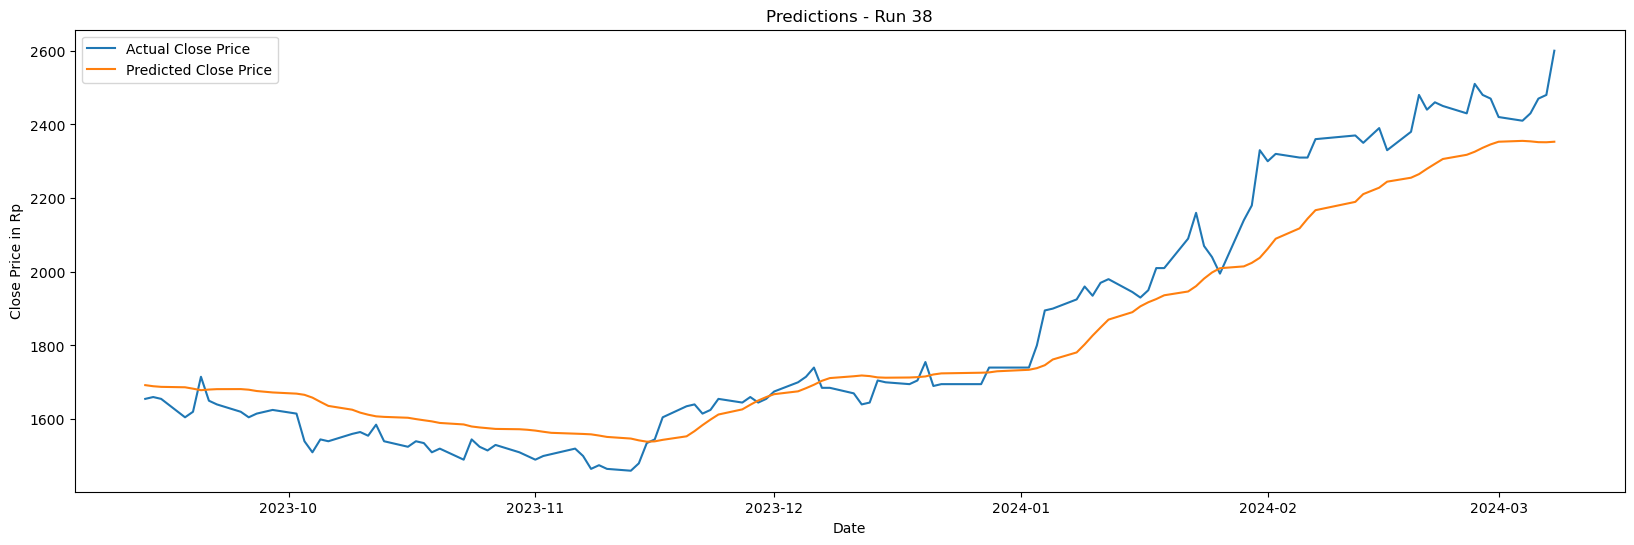

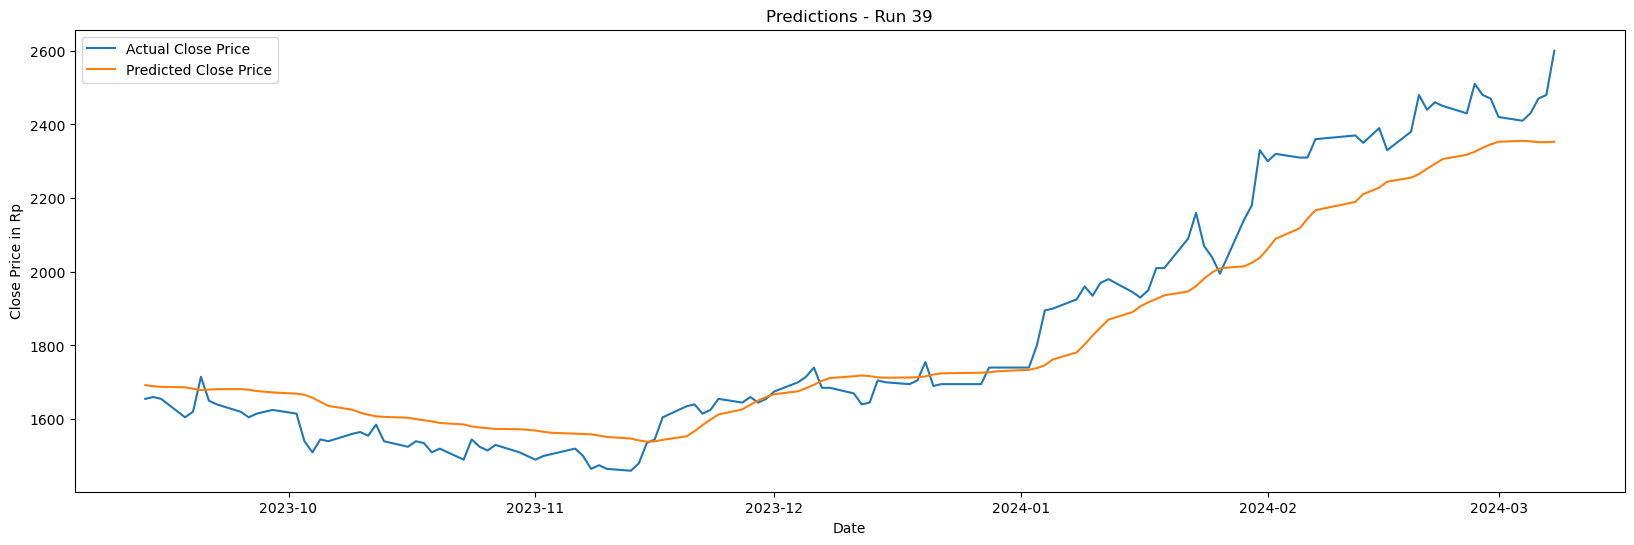

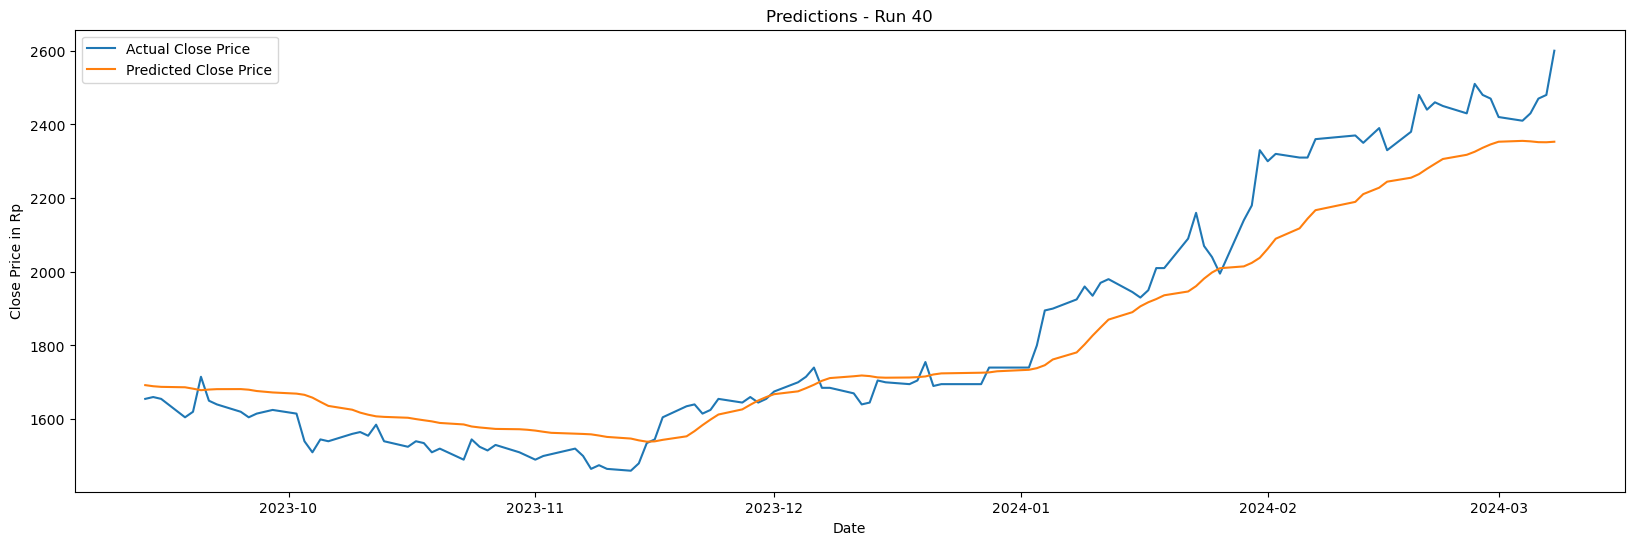

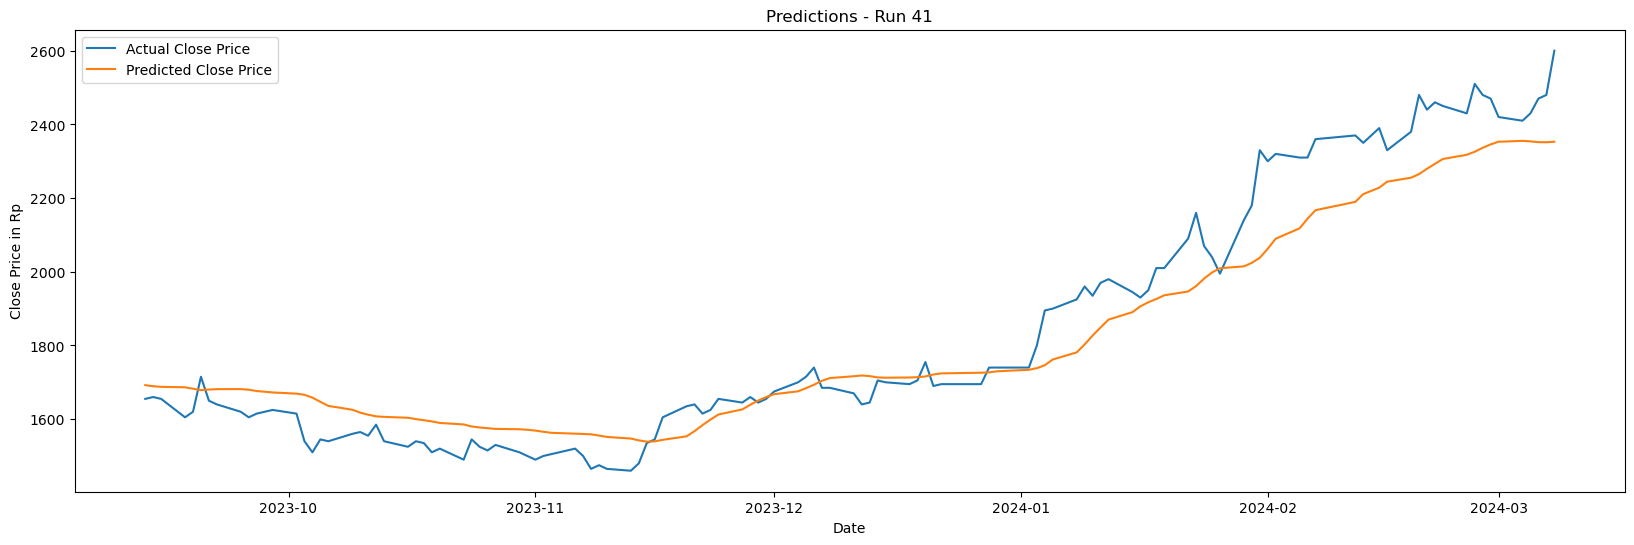

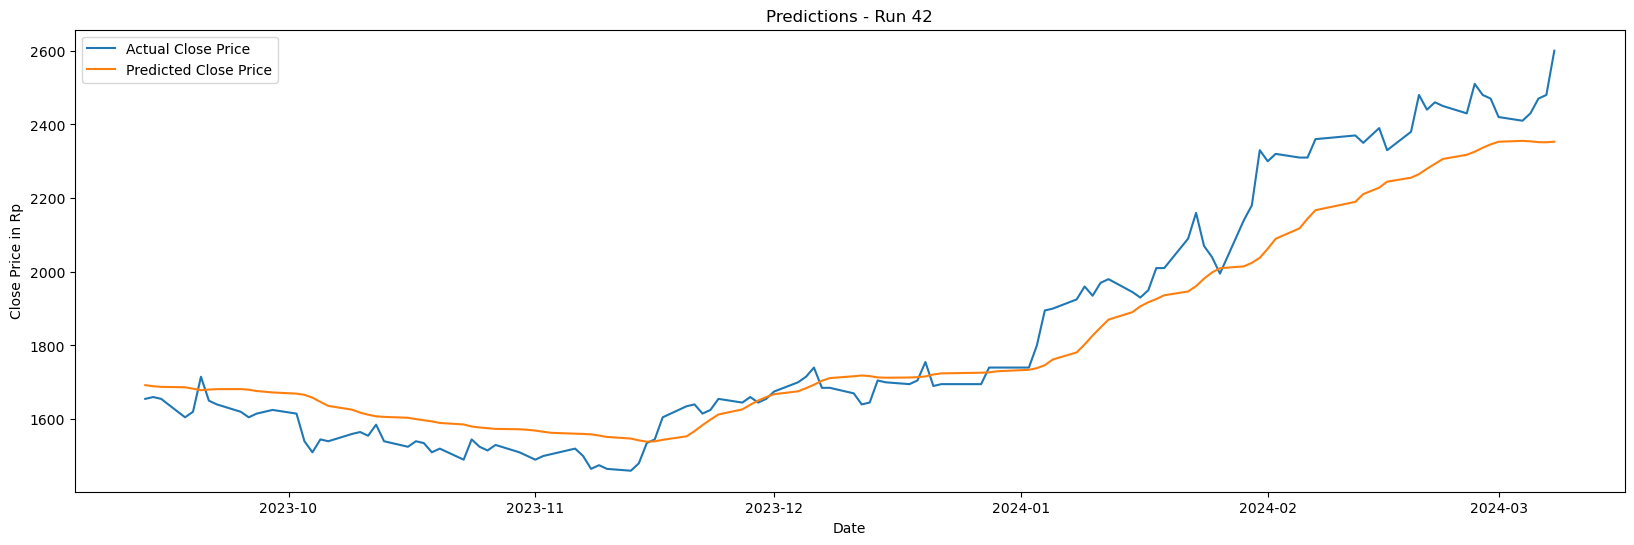

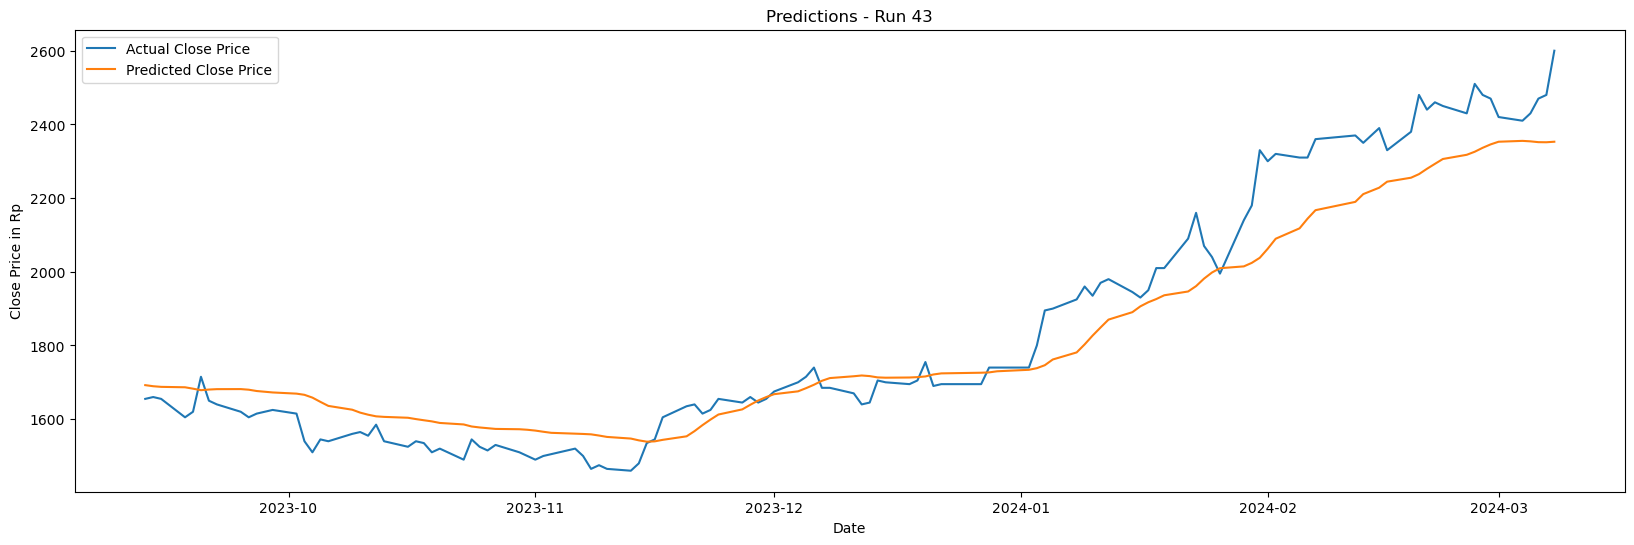

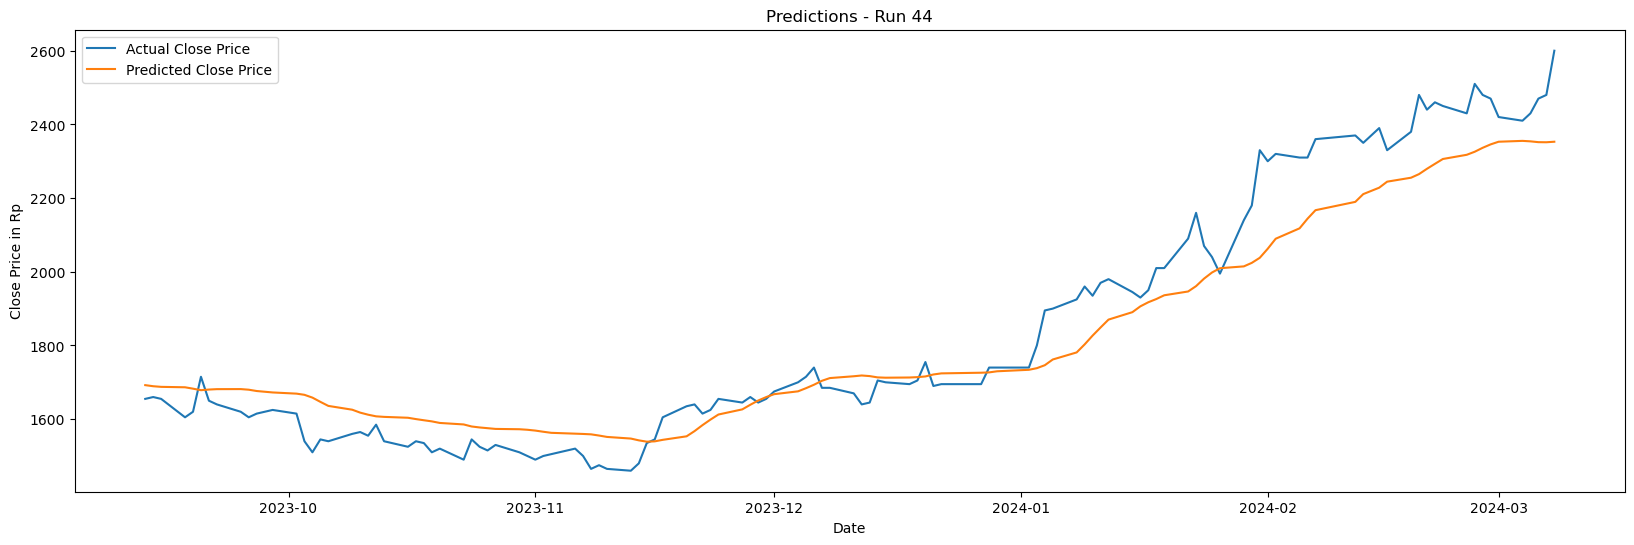

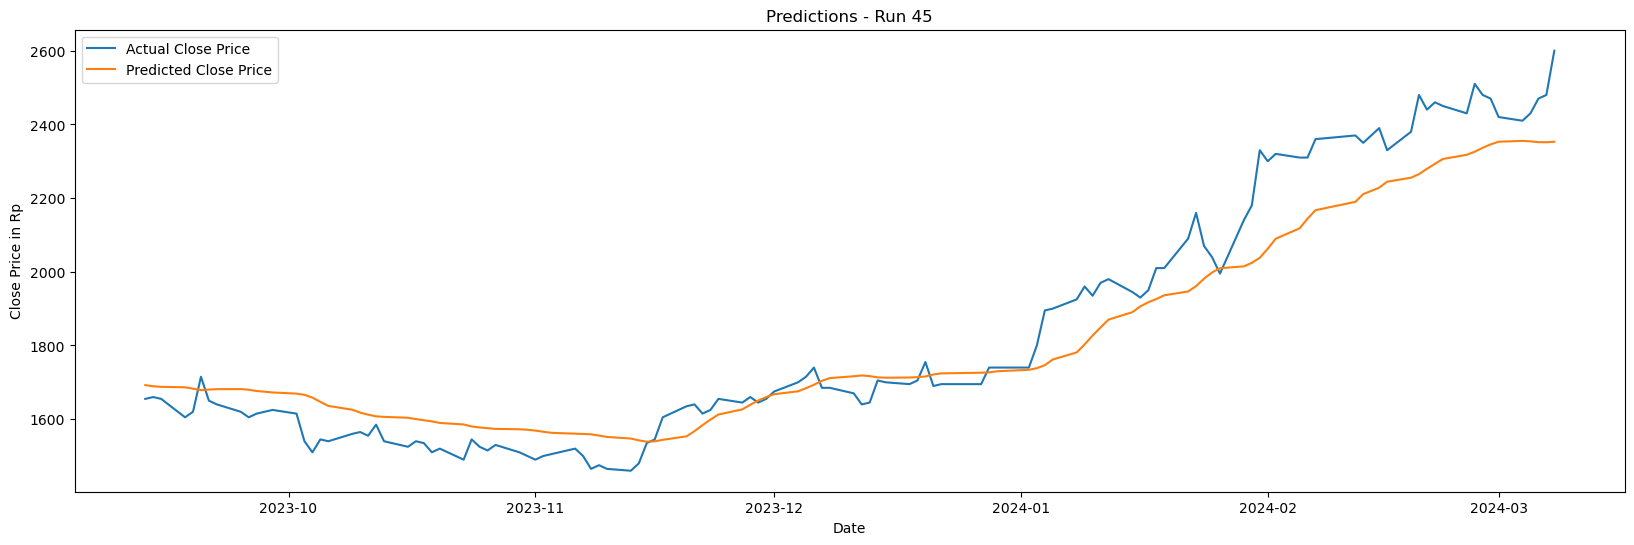

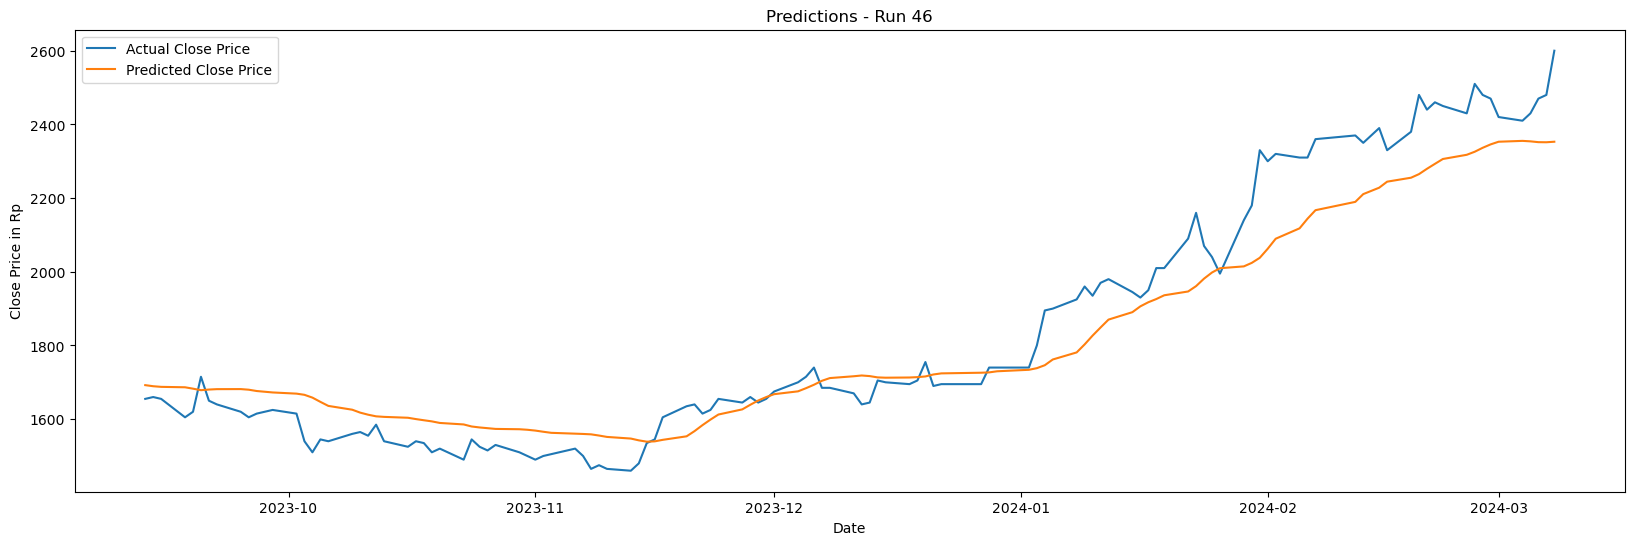

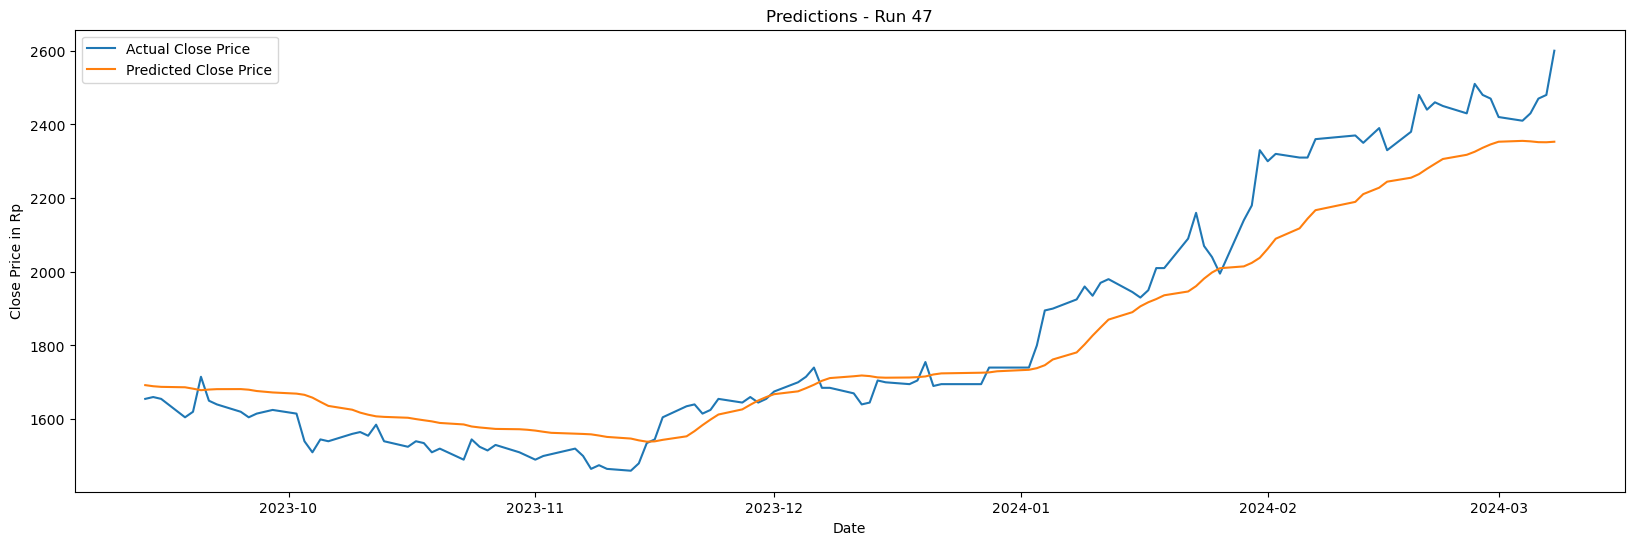

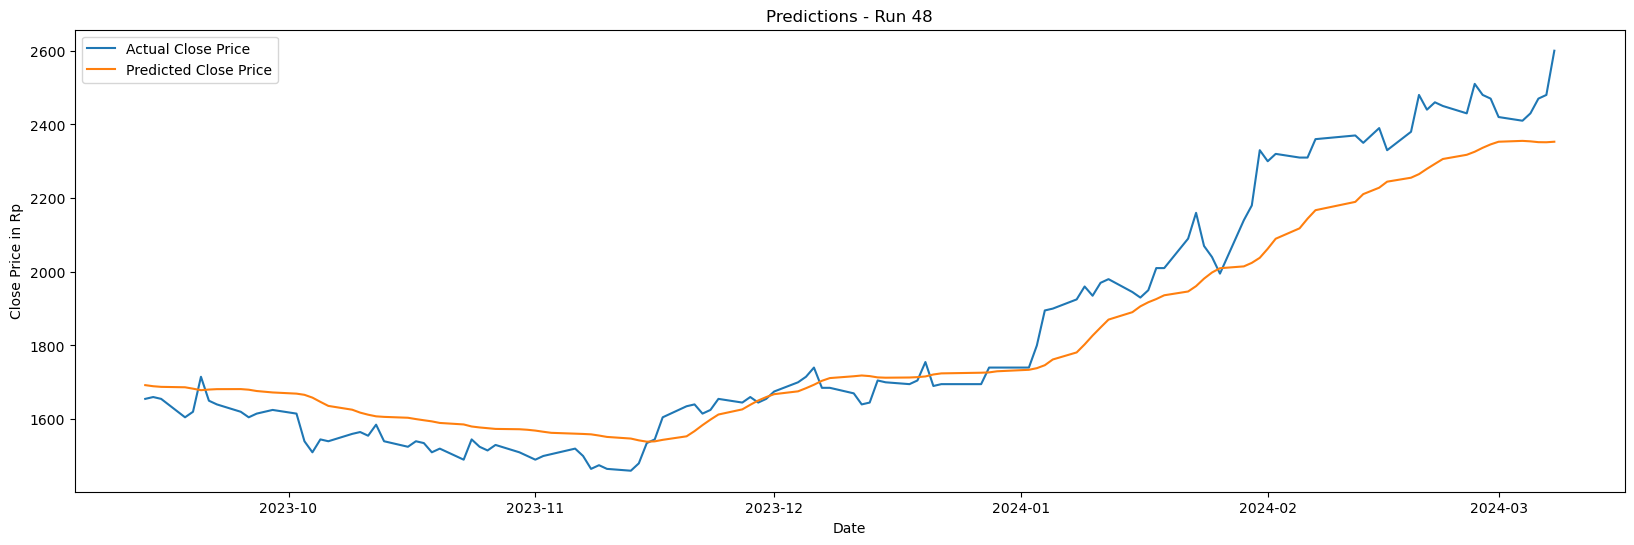

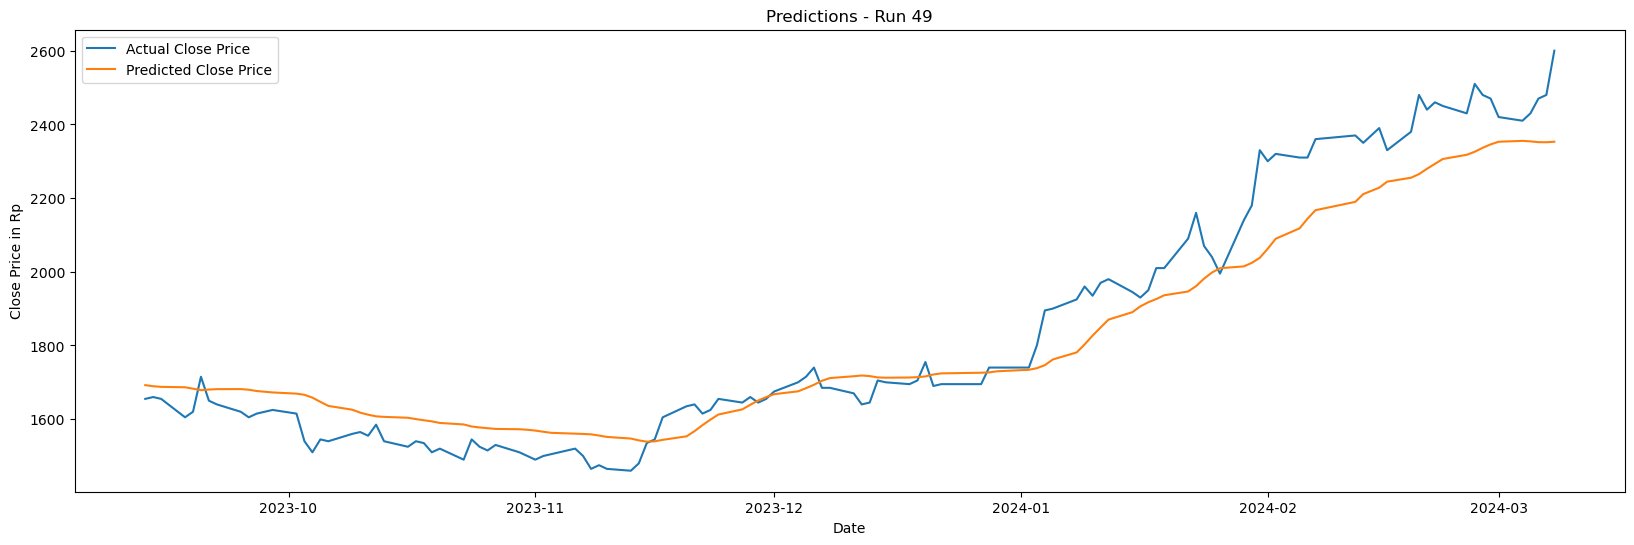

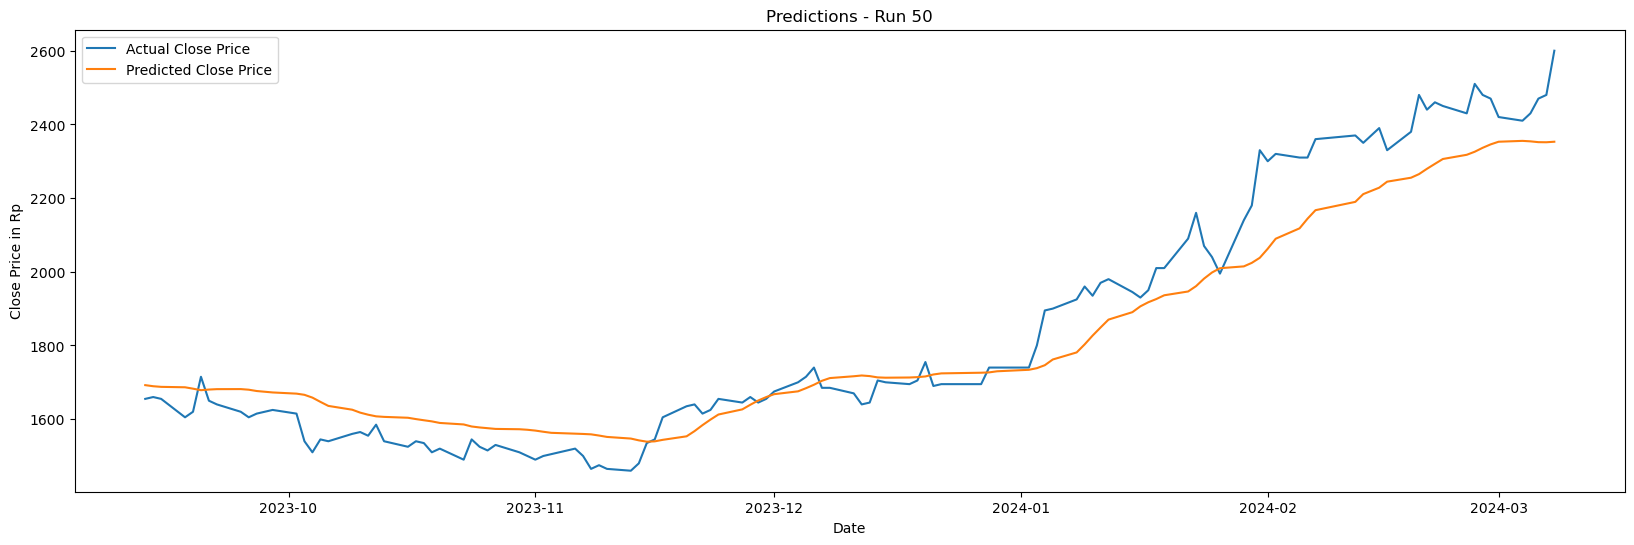

In [10]:
for i in range(50):
    # Plot predictions
    plt.figure(figsize=(20,6))
    plt.plot(data.index[training_data_len:], data['Close'][training_data_len:], label='Actual Close Price')
    plt.plot(data.index[training_data_len:], predictions, label='Predicted Close Price')
    plt.title(f'Predictions - Run {i+1}')
    plt.xlabel('Date')
    plt.ylabel('Close Price in Rp')
    plt.legend()
    plt.show()

In [11]:
# Ambil kolom 'Average_Prediction'
average_prediction = results_df['Average_Prediction'].copy()

# Hapus 2 baris terakhir dari 'average_prediction'
average_prediction = average_prediction.iloc[:-2]

# Buat DataFrame baru dengan kolom 'Average_Prediction'
new_dataframe = pd.DataFrame(average_prediction, columns=['Average_Prediction'])

# Atur kolom 'Date' dari data sebagai indeks
new_dataframe.index = data.index[training_data_len:]

# Tambahkan kolom 'Actual' dari data asli
new_dataframe['Actual'] = data['Close'][training_data_len:]  

# Tampilkan DataFrame baru
print(new_dataframe)

            Average_Prediction  Actual
Date                                  
2023-09-13         1694.715239  1655.0
2023-09-14         1692.087083  1660.0
2023-09-15         1690.970491  1655.0
2023-09-18         1690.449358  1605.0
2023-09-19         1686.494272  1620.0
...                        ...     ...
2024-03-04         2346.861899  2410.0
2024-03-05         2343.145156  2430.0
2024-03-06         2339.012646  2470.0
2024-03-07         2337.936748  2480.0
2024-03-08         2339.306802  2600.0

[121 rows x 2 columns]


In [12]:
# Save DataFrame to CSV with header
new_dataframe.to_csv('BRISLSTMvsActualW100.csv', header=True)

In [13]:
import numpy as np
from sklearn.metrics import mean_squared_error

def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Fetch LSTM's Prediction (Average_Prediction) and the Actual data
predictions = new_dataframe['Average_Prediction']
actual = new_dataframe['Actual']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predictions))

# Calculate MAPE
mape = calculate_mape(actual, predictions)

# Print RMSE & MAPE
print('RMSE:', rmse)
print('MAPE:', mape)

RMSE: 97.77073213901839
MAPE: 4.113490730523068


/var/folders/dx/r9qzc02n76vb2zj4g6731w_r0000gn/T/ipykernel_51027/2582833144.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


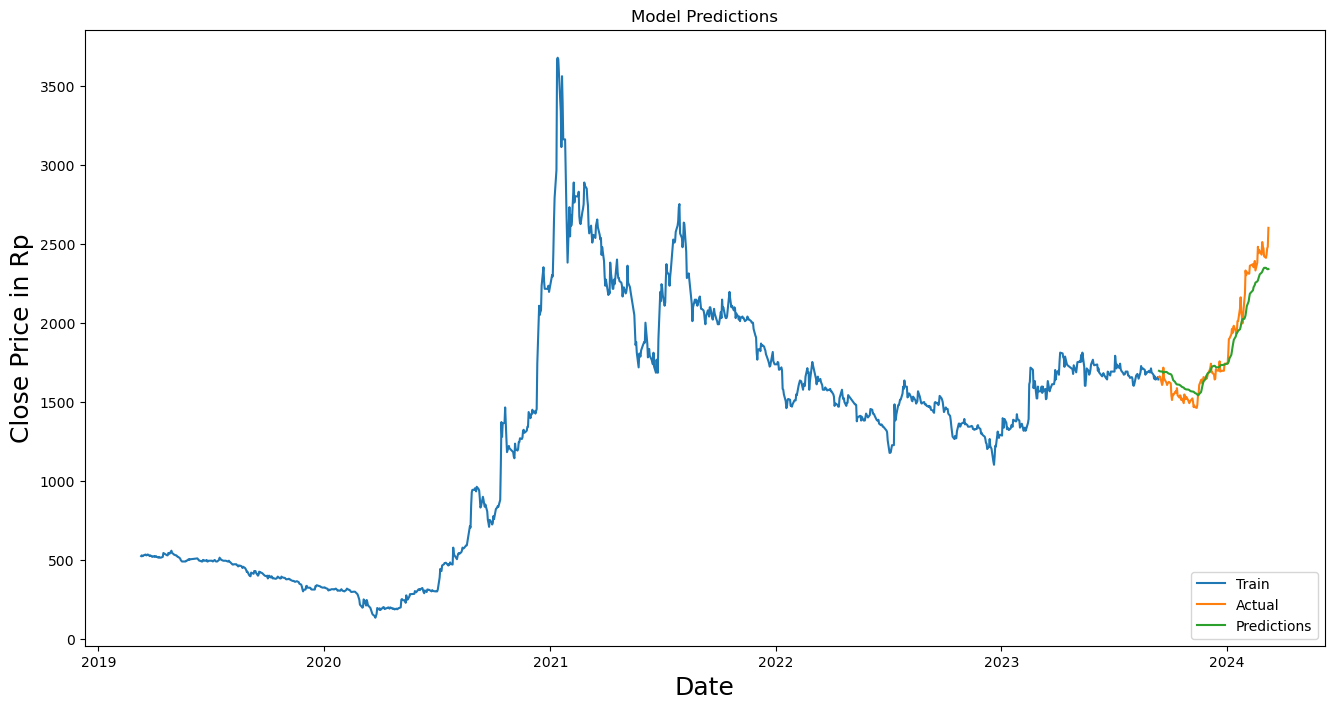

In [14]:
# Fetch testing and training data
train = data[:training_data_len]
valid = data[training_data_len:]

# Add 'Predictions'
valid['Predictions'] = predictions

# Plotting 
plt.figure(figsize=(16,8))
plt.title('Model Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in Rp', fontsize=18)

# Plot training data
plt.plot(train['Close'], label='Train')

# Plot actual and prediction
plt.plot(valid['Close'], label='Actual')
plt.plot(valid['Predictions'], label='Predictions')

# Add legend
plt.legend(loc='lower right')
plt.show()

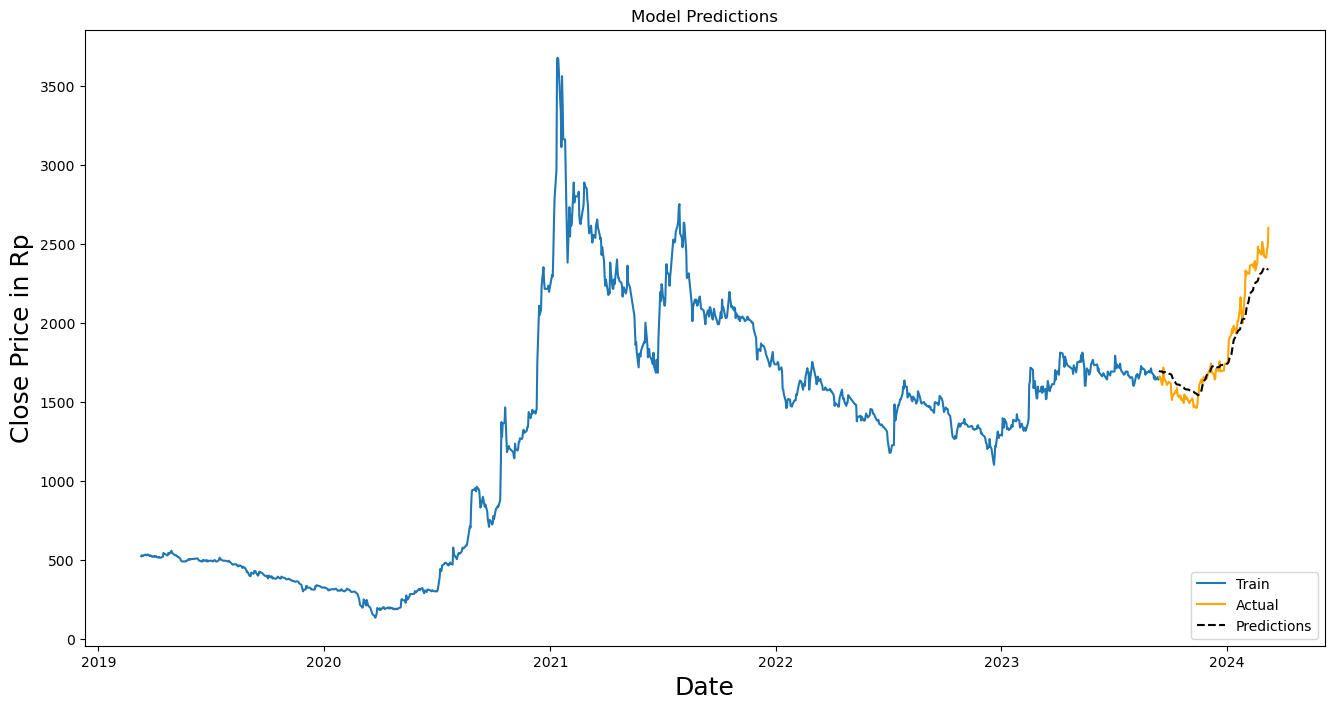

In [15]:
# Plotting 
plt.figure(figsize=(16,8))
plt.title('Model Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in Rp', fontsize=18)

# Plot training data
plt.plot(train['Close'], label='Train')

# Plot actual data
plt.plot(valid.index, valid['Close'], label='Actual', linestyle='-', color='orange')

# Plot prediction data
plt.plot(valid.index, valid['Predictions'], label='Predictions', linestyle='--', color='black')

# Add legend
plt.legend(loc='lower right')
plt.show()